# Assignment 1

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: POS tagging, Sequence labelling, RNNs

### Import necessary libraries

In [177]:
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torchtext
import random 
import math
from torch import zeros
from torchtext.vocab import GloVe
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
import seaborn as sns
from sys import stdout
from json import dumps
from itertools import combinations
from typing import Tuple, Literal
from warnings import filterwarnings
flush, write = stdout.flush , stdout.write
filterwarnings('ignore')

# [Task 1 - 0.5 points] Corpus

You are going to work with the [Penn TreeBank corpus](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip).

**Ignore** the numeric value in the third column, use **only** the words/symbols and their POS label.

### Example

```Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8
```

### Dataset download

In [3]:
%%capture
!curl -O https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip
!unzip -o dependency_treebank.zip

### Splits

The corpus contains 200 documents.

   * **Train**: Documents 1-100
   * **Validation**: Documents 101-150
   * **Test**: Documents 151-199

### Dataset import

In [4]:
#This functions are usefull to import the data from a given range of files

def pad(x, tot_len, pad_val):
  l = len(x)
  return ''.join([pad_val for _ in range(tot_len - l)]) + x

def import_corpus(folder:'str', file_base:'str', corpus_range:'range', separator:'str', data:'object'):
  keys = list(data.keys())
  data_len = len(keys)
  data['source file'] = []
  for i in corpus_range:
    f = open(f'{folder}/{file_base}{pad(str(i), 4, "0")}.dp')
    for line in f.readlines():
      entry = line.replace('\n','').split(separator)
      if len(entry) >= data_len:
        for j in range(data_len):
            data[keys[j]].append(entry[j])
        data['source file'].append(f'{file_base}{pad(str(i), 4, "0")}')
    f.close()
  return data

In [5]:
SEPARATOR = '\t'
folder = 'dependency_treebank'
file_base = 'wsj_'

train_data = pd.DataFrame(import_corpus(folder, file_base, range(1,101), SEPARATOR, {'word/symbol':[], 'pos label':[]}))
validation_data = pd.DataFrame(import_corpus(folder, file_base, range(101,151), SEPARATOR, {'word/symbol':[], 'pos label':[]}))
test_data = pd.DataFrame(import_corpus(folder, file_base, range(151,200), SEPARATOR, {'word/symbol':[], 'pos label':[]}))
train_data

word/symbol pos label source file
0          Pierre       NNP    wsj_0001
1          Vinken       NNP    wsj_0001
2               ,         ,    wsj_0001
3              61        CD    wsj_0001
4           years       NNS    wsj_0001
...           ...       ...         ...
47351   challenge        NN    wsj_0100
47352          he       PRP    wsj_0100
47353         has       VBZ    wsj_0100
47354       faced       VBN    wsj_0100
47355           .         .    wsj_0100

[47356 rows x 3 columns]

# [Task 2 - 0.5 points] Text encoding

In [6]:
EMBEDDING_DIM = 300 #This will be the encoding dimension of our embeddings

In [7]:
#let's download glove
glove = GloVe(name='6B', dim=EMBEDDING_DIM)

Let's explore our embedding:

In [8]:
i = 50
word = train_data.iloc[i]["word/symbol"]
print(f"word at position {i}: {word}")
print(f'embedding: \n {glove[word]}')

word at position 50: director
embedding: 
 tensor([-0.0687, -0.3939,  0.4573, -0.2854,  0.0459, -0.8392, -0.4326, -0.1727,
         0.0622, -0.8511,  0.6977, -0.0665, -0.5244,  0.1738, -0.4251, -0.2834,
         0.1151,  0.0082,  0.2757,  0.3627,  0.1709, -0.0102,  0.3263, -0.2441,
        -0.2870,  1.0194,  0.0812, -0.1947, -0.3475,  0.0832,  0.2689,  0.0258,
         0.2926,  0.5827, -1.1648, -0.1290,  0.2042, -0.3246,  0.1513, -0.3418,
         0.1427, -0.1080,  0.3433,  0.3846, -0.2748, -0.5318, -0.7224,  0.2173,
        -0.3238, -0.2323, -0.3550, -0.0930, -0.0943,  0.2398, -0.1305,  0.4682,
        -0.1757,  0.4127, -0.3832, -0.2612, -0.6611,  0.2374,  0.9375, -0.0258,
         0.0292, -0.0821, -0.2386,  0.0925,  0.2736, -0.6830, -0.2301,  0.4784,
        -0.0183,  0.0266, -0.1814,  0.0901,  0.1913,  0.2784, -0.0887, -0.2237,
        -0.1041,  0.2955,  0.0794,  0.2641,  0.0428,  0.1922, -0.1825,  0.1555,
        -0.1752, -0.4648, -0.3614, -0.1607, -0.3183, -0.1791, -0.2749,  0.154

## Useful classes

### Dataset
it is a usefull class that helps creating a dataloader which is very usefull for training a network since it automatically manages batches

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

### Vocabulary
It is a class that really helps with managing the words in our dataset. it creates 3 structures:
  - `word2idx` which is a dictionary that maps every word to the corresponding token.
  - `idx2word` which is a list that works as the inverse function to `word2idx` mapping back every token to the corresponding word.
  - `vectors` which is a list that maps every token to the corresponding embedding vector. If no embedding vector has been given for the corresponding word, the vectors list will return a 0 tensor.

In addition, the `length` variable will contains the length of the embedding vectors and `dim` will contains the size of the vocabulary.

In [10]:
class Vocabulary:
  """
  A class containing all the words used in the training.

  Attributes
  ----------
  word2idx : Dict
    Maps every word to the corresponding token.
  idx2word : List[str]
    Works as the inverse function to `word2idx` mapping back every token to the corresponding word.
  vectors : list[torch.Tensor]
    maps every token to the corresponding embedding vector. If no embedding vector has been given for the corresponding word, the vectors list will return a 0 tensor.
  length : int
    contains the length of the embedding vectors.
  dim : int
    contains the size of the vocabulary.
  """
  def __init__(self,
               words:'list[str]',
               pretrained_vectors: 'torchtext.vocab.Vectors' = None,
               specials:'list[str]' = ['<unk>', '<pad>'],
               vectors_length:'int' = -1) -> None:
    """
    Parameters
    ----------
    words: list[str]
      The unique words contained in the vocabulary
    pretrained_vectors: torchtext.vocab.Vectors
      the pretrained embedding containing the Tensors that will be used for the embedding. If there are words included in this class not included in the `words` list they will be added to the vocabulary too.
      It can be None but, in this case, a 0 Tensor will be created for the embedding. In the case this value is None, the `vectors_length` is mandatory.
    specials: list[str]
      A list that contains the special tokens that will be added to the vocabulary. This token will be the first tokens in the resulting list.
    vectors_length: int
      This parameter is mandatory only if the `pretrained_vectors` parameter is None. It represent the length of each Tensor used in the embedding.
    """
    self.__word2idx = {}
    self.idx2word = []
    self.vectors = []

    self.pre_trained = pretrained_vectors != None

    pre_keys = []
    pre_vectors = {}

    if self.pre_trained:
      pre_keys = pretrained_vectors.stoi.keys()
      pre_vectors = pretrained_vectors

    self.length = vectors_length
    if self.pre_trained:
      self.length = len(pretrained_vectors.vectors[0])
      if vectors_length != -1 and self.length != vectors_length:
        raise Exception(f"vectors_length {vectors_length} incompatible with length of pretrained_vectors {self.length}. Consider removing the vector length property")
    if self.length == -1:
      raise Exception("either a the pretrained_vectors or the vectors_length properties should be provided")

    idx = 0

    for word in specials:
      self.__add_word(word, idx, pre_keys, pre_vectors)
      idx += 1

    for word in pre_keys:
      self.__add_word(word, idx, pre_keys, pre_vectors)
      idx += 1

    for word in words:
      if not word in self.__word2idx:
        self.__add_word(word, idx, pre_keys, pre_vectors)
        idx += 1

    self.dim = idx
    self.vectors = torch.stack(self.vectors)

  def word2idx(self, word):
    if word in self.__word2idx:
      return self.__word2idx[word]
    return self.__word2idx['<unk>']

  def __add_word(self, word:'str', idx:'int', pre_keys:'list', pre_vectors: 'dict') -> None:
      self.__word2idx[word] = idx
      self.idx2word.append(word)
      self.vectors.append(pre_vectors[word] if word in pre_keys else zeros(self.length))

In [11]:
vocabulary = Vocabulary(np.unique(train_data['word/symbol']), glove)

Let's explore our vocabulary:

In [12]:
word = 'director'
idx = vocabulary.word2idx('director')
print(f"the index of the word {word} is: {idx}")
print(f"the word of the index {idx} is: {vocabulary.idx2word[idx]}")
print(f"the embedding of the word {word} at index {idx} is:\n\t{vocabulary.vectors[idx]}")

the index of the word director is: 371
the word of the index 371 is: director
the embedding of the word director at index 371 is:
	tensor([-0.0687, -0.3939,  0.4573, -0.2854,  0.0459, -0.8392, -0.4326, -0.1727,
         0.0622, -0.8511,  0.6977, -0.0665, -0.5244,  0.1738, -0.4251, -0.2834,
         0.1151,  0.0082,  0.2757,  0.3627,  0.1709, -0.0102,  0.3263, -0.2441,
        -0.2870,  1.0194,  0.0812, -0.1947, -0.3475,  0.0832,  0.2689,  0.0258,
         0.2926,  0.5827, -1.1648, -0.1290,  0.2042, -0.3246,  0.1513, -0.3418,
         0.1427, -0.1080,  0.3433,  0.3846, -0.2748, -0.5318, -0.7224,  0.2173,
        -0.3238, -0.2323, -0.3550, -0.0930, -0.0943,  0.2398, -0.1305,  0.4682,
        -0.1757,  0.4127, -0.3832, -0.2612, -0.6611,  0.2374,  0.9375, -0.0258,
         0.0292, -0.0821, -0.2386,  0.0925,  0.2736, -0.6830, -0.2301,  0.4784,
        -0.0183,  0.0266, -0.1814,  0.0901,  0.1913,  0.2784, -0.0887, -0.2237,
        -0.1041,  0.2955,  0.0794,  0.2641,  0.0428,  0.1922, -0.1825

## Data pre-processing and preparation

---



### PosEncoding
It is a similar class to Vocabulary but for the position. It works basically the same but with the one-hot-encoding instead of the embedding.

In [13]:
class PosEncoding:
  """
  A class containing all the pos values used in the training.

  Attributes
  ----------
  pos2idx : Dict
    Maps every pos to the corresponding token.
  idx2pos : List[str]
    Works as the inverse function to `pos2idx` mapping back every token to the corresponding pos.
  encoding : list[torch.Tensor]
    maps every pos to the corresponding one-hot-encoded vector.
  dim : int
    contains the size of the vocabulary.
  """
  def __init__(self, pos_labels: 'list[str]', specials:'list[str]' = ['<pad>']) -> None:
    """
    Parameters
    ----------
    pos_labels: list[str]
      The unique words contained in the vocabulary
    specials: list[str]
      A list that contains the special pos that will be added to the vocabulary.
    """
    self.pos2idx = {}
    self.idx2pos = []
    self.encoding = []
    starting_tensor = [0 for _ in range(len(pos_labels) + len(specials))]
    idx = 0

    for pos in specials:
      self.__add_pos(pos, idx, starting_tensor)
      idx += 1

    for pos in pos_labels:
      self.__add_pos(pos, idx, starting_tensor)
      idx += 1


  def __add_pos(self, pos:'str', idx:'int', starting_tensor:'torch.Tensor'):
    self.pos2idx[pos] = idx
    self.idx2pos.append(pos)
    self.encoding.append(starting_tensor.copy())
    self.encoding[idx][idx] = 1


### position labels encoding

In [14]:
pos_labels = np.unique(train_data['pos label'])
number_of_pos_labels = len(pos_labels)
print(f'there are {number_of_pos_labels} unique pos label values: ' + "\n- " + "\n- ".join(pos_labels))

there are 45 unique pos label values: 
- #
- $
- ''
- ,
- -LRB-
- -RRB-
- .
- :
- CC
- CD
- DT
- EX
- FW
- IN
- JJ
- JJR
- JJS
- LS
- MD
- NN
- NNP
- NNPS
- NNS
- PDT
- POS
- PRP
- PRP$
- RB
- RBR
- RBS
- RP
- SYM
- TO
- UH
- VB
- VBD
- VBG
- VBN
- VBP
- VBZ
- WDT
- WP
- WP$
- WRB
- ``


In [15]:
pos_encoding = PosEncoding(pos_labels)

Let's expolore our positional encoding:

In [16]:
pos = 'NNP'
pos_idx = pos_encoding.pos2idx[pos]
print(f'the index of the pos "{pos}" is: {pos_idx}')
print(f'the pos of the index {pos_idx} is: {pos_encoding.idx2pos[pos_idx]}')
print(f'the One HOt Encoding of the pos "{pos}" is:\n\t{pos_encoding.encoding[pos_idx]}')

the index of the pos "NNP" is: 21
the pos of the index 21 is: NNP
the One HOt Encoding of the pos "NNP" is:
	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Data transformation
We need to partition the data into sentences, treating each file as a document for this purpose. However, using each file as a unit of data split may not be optimal, as it could lead to excessively long sentences, adversely affecting the performance of the LSTM. Another drawback to this approach is that it would result in multiple sentences within each row, adding no value to the model while slowing down the inference process.

A more effective strategy is to segment the data based on punctuation marks such as "!", "?", ".", and ";". This approach is anticipated to enhance the model's performance. However, a potential downside arises in situations like the following:

```
The cat said: "Meow!" and jumped over the table.
```

Using punctuation-based splitting would yield the following output:

```
["The cat said:\"Meow!\"", "and jumped over the table."]
```

This output incorrectly separates a single sentence into two. To address such cases, we propose a rule: whenever an open quotation mark is encountered, it must be closed before proceeding with sentence splitting.

In [17]:
def tail_pad(x, tot_len, pad_element):
  l = len(x)
  return x + [pad_element for _ in range(tot_len - l)]

def transform_data(input_data:'pd.Dataframe', vocab:'Vocabulary', encoding:'PosEncoding') -> Tuple[torch.Tensor, torch.Tensor]:
  """
    A function that returns a tuple containing two Tensor, the first containg the tokenized words of the dataframe, the second containing the encoded labels of the dataframe.
    Parameters
    ----------
    input_data: pd.Dataframe
      The dataframe containing the data to transform. The value of the words will be checked in the 'word/symbol' column while the label will be cheked in the pos label one. If the sentence_split parameter is false, the elements will be grouped by the source file column.
    vocab: Vocabulary
      The vocabulary used to tokenize the words.
    encoding: PosEncoding
      The encoding of the labels.
    sentence_split: bool
      It tells how to split the sentences: if tru, they will be split by the '.' token, if false they will be split by the source file.
  """
  out_lists_x = [[]]
  out_lists_y = [[]]
  idx = 0
  quote_open, quote_close = False, False
  eos = False
  file = False
  for i in range(input_data.shape[0]):
    row = input_data.iloc[i, :]
    word = row['word/symbol']
    out_lists_x[idx].append(word)
    out_lists_y[idx].append(row['pos label'])
    eos = word == '.' or word == ';' or word == '!' or word == '?'
    quote_open = (word == '\'\'' or word == '``') and not quote_close
    quote_close = (word == '\'\'' or word == '``') and quote_open
    next = min(i + 1, input_data.shape[0] - 1)
    file = input_data.iloc[next, :]['source file'] != input_data.iloc[i, :]['source file']
    if (eos and (quote_close or (not quote_open))) or file:
      eos = False
      quote_open, quote_close = False, False
      file = False
      out_lists_x.append([])
      out_lists_y.append([])
      idx += 1
  max_len = 0
  if len(out_lists_x[-1]) == 0:
    out_lists_x = out_lists_x[:-1]
    out_lists_y = out_lists_y[:-1]
  for sentence in out_lists_x:
    if len(sentence) > max_len:
      max_len = len(sentence)
  for i in range(len(out_lists_x)):
    out_lists_x[i] = tail_pad(out_lists_x[i], max_len, '<pad>')
    out_lists_y[i] = tail_pad(out_lists_y[i], max_len, '<pad>')
    token_words = []
    for word in out_lists_x[i]:
      token_words.append(vocab.word2idx(word))
    encoded_y = []
    for pos in out_lists_y[i]:
      encoded_y.append(encoding.encoding[encoding.pos2idx[pos]])
    out_lists_x[i] = token_words
    out_lists_y[i] = encoded_y
  return torch.LongTensor(out_lists_x), torch.Tensor(out_lists_y)

In [18]:
x_train, y_train = transform_data(train_data, vocabulary, pos_encoding)
x_validation, y_validation = transform_data(validation_data, vocabulary, pos_encoding)

# [Task 3 - 1.0 points] Model definition

You are now tasked to define your neural POS tagger.

In [19]:
# first, let's see if there is a gpu available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)

Device: cuda


## LSTM Layer

A very simple layer. It creates a LSTM that can be used with the `NeuralNetwork` class. It just wrap the [nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) class returning only the output value and discarding the internal states

In [20]:
class LSTMLayer(nn.Module):
  """
  A very simple layer. It creates a LSTM that can be used with the `NeuralNetwork` class.
  """
  def __init__(self, input_size:'int', hidden_size:'int', bidirectional:'bool') -> None:
    """
    Parameters
    ----------
    input_size: int
      The size of the input to the LSTM layer.
    hidden_size: int
      The number of LSTM layers.
    bidirectional: bool
      If the LSTM layer are birectional or not.
    """
    super(LSTMLayer, self).__init__()
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=bidirectional)

  def forward(self, x):
    out, _ = self.lstm(x)
    return out

## Embed Layer

### Replace embedding
This layer handles the embedding of the tokens. It contains two embedding layers: the first assumes that there are pretrained vectors to use \(vector given as arguments to the `__init__` function\), the second one covers the values that are not present in the pretrained vector. The second embedding layer will be initialized with random values.

The first embedding layer can be frozen in order to avoid training it.

### How the replace Embedding layer works
![img](https://drive.google.com/uc?export=view&id=1tC7yKZwKDkv6RkBK4nU5kz3ckKocnJf4)

In [21]:
class EmbedLayer_replace(nn.Module):
  def __init__(self, vocabulary, embedding_dim):
        super(EmbedLayer_replace, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocabulary.vectors)
        self.oov_embedding = nn.Embedding(vocabulary.dim, embedding_dim)
        nn.init.uniform_(self.oov_embedding.weight, -1.0, 1.0)

  def freeze(self, freeze:'bool'):
    self.embedding.freeze = freeze


  def forward(self, x):
    embedded = self.embedding(x)
    mask = (embedded[:, :, -1] == 0).nonzero()

    embedded[mask[:, 0], mask[:, 1], :] = self.oov_embedding(x[mask[:, 0], mask[:, 1]])
    return embedded


### Sum embedding
This second version of the embedding works a bit differently: It sums the two embedding values instead of replacing the oov words only. The second random embedding should  work as "fine-tuning" layer for training words and be the only embedding for non-pretrained words.

NOTE: When the pretrained layer is freezed, we also do not compute the values from the oov embedding for the tokens available in the pretrained embedding layer. 

### How the sum Embedding layer works
![img](https://drive.google.com/uc?export=view&id=1RrF4tv5YD7gNgjzTJXpeUq3LgQQGAAyH)

In [22]:
class EmbedLayer_sum(nn.Module):
  def __init__(self, vocabulary, embedding_dim):
        super(EmbedLayer_sum, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocabulary.vectors)
        self.oov_embedding = nn.Embedding(vocabulary.dim, embedding_dim)
        self.is_freezed = False
        nn.init.uniform_(self.oov_embedding.weight, -1.0, 1.0)

  def freeze(self, freeze:'bool'):
    self.embedding.freeze = freeze
    self.is_freezed = freeze


  def forward(self, x):
    pre_trained_embedded = self.embedding(x)
    
    if self.is_freezed:
      mask = (pre_trained_embedded[:, :, -1] == 0).nonzero()
      pre_trained_embedded[mask[:, 0], mask[:, 1], :] = self.oov_embedding(x[mask[:, 0], mask[:, 1]])
      return pre_trained_embedded
    
    oov_embeds = self.oov_embedding(x)
    return pre_trained_embedded + oov_embeds

## NeuralNetwork
This class is a really simple class that helps with crating a neural network. It implements a simple training loop that will be available for every class deriving from it.

In [23]:
class NeuralNetwork(nn.Module):
  """
  This class implements a simple interface to get a working neural network using pytorch.
  """
  def __init__(self) -> None:
     super().__init__()
     
  def train_network(self,
            train_loader:'torch.utils.data.DataLoader',
            validation_loader:'torch.utils.data.DataLoader',
            optimizer = torch.optim.Adam, 
            loss_function = nn.CrossEntropyLoss(),
            learning_rate:'float'=.1,
            epochs:'int'=10,
            device:'str'='cpu',
            output_extraction_function:'callable' = lambda x: torch.round(x).detach().cpu(),
            metrics:'dict[str,callable]' = {},
            verbose:'bool' = True) -> Tuple[dict[str,list[float]],dict[str,list[float]]]:
    """
      A simple training loop for the neural network. It returns the epochs loss and accuracy history both on the training and the validation set. The tuple will be formatted as:
      train loss, train accuracy, val loss, val accuracy
      Parameters
      ----------
      train_loader: torch.utils.data.DataLoader
        A dataloader containing the dataset that will be used for training the network
      validation_loader: torch.utils.data.DataLoader
        A dataloader containing the dataset that will be used for validate the network at the end of each epoch
      optimizer:
        The optimizer to use while training, default to Adam.
      loss_function:
        The loss function to use while training, default to crossentropy
      learning_rate: float
        The learning rate that will be used in the optimizer to train the network. Default to .1
      epochs:
        The number of training epochs, default to 10.
      device:
        The device to use for the computation
      metrics:
        The metrics to use to evaluate the network
    """
    net = self.to(device)
    optimizer = optimizer(net.parameters(), learning_rate)

    train_loss_history = []
    val_loss_history = []

    total_batch = int(len(train_loader.dataset) / train_loader.batch_size)
    train_metrics_scores = {}
    val_metrics_scores = {}
    for key in metrics:
        train_metrics_scores[key] = []
        val_metrics_scores[key] = []

    for epoch in range(epochs):
        net.train()
        for batch_idx, data in enumerate(train_loader):
            labels = data[1].to(device)
            if isinstance(data[0], dict):
              inputs = {}
              for key in data[0].keys():
                 inputs[key] = data[0][key].to(device)
            else:
              inputs = data[0].to(device)
            outputs = net(inputs)
            n_batch, n_sequence, n_classes = outputs.shape
            loss_outputs = torch.reshape(outputs, (n_batch, n_classes, n_sequence))
            loss_labels = torch.reshape(labels, (n_batch, n_classes, n_sequence))
            loss = loss_function(loss_outputs, loss_labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            predicted_classes = output_extraction_function(outputs)
            normal_labels = output_extraction_function(labels)
            if verbose:
              write(f"\rbatch {batch_idx + 1}/{total_batch} ----- loss: {loss.cpu()} ----- {'-----'.join([f'{key}: {metrics[key](predicted_classes, normal_labels)}' for key in metrics.keys()])}")
              flush()

        val_metrics, val_loss = self.__validate(validation_loader, metrics, loss_function, device, output_extraction_function)
        for key in metrics:
          val_metrics_scores[key].append(val_metrics[key])
        val_loss_history.append(val_loss)
        train_metrics, train_loss = self.__validate(train_loader, metrics, loss_function, device, output_extraction_function)
        for key in metrics:
          train_metrics_scores[key].append(train_metrics[key])
        train_loss_history.append(train_loss)
        if verbose:
          out_str =f"EPOCH {epoch + 1} training loss: {train_loss_history[-1]} - validation loss: {val_loss_history[-1]}\n" + \
          '\n'.join([f"EPOCH {epoch + 1} training {metric}: {train_metrics_scores[metric][-1]} - validation {metric}: {val_metrics_scores[metric][-1]}" for metric in metrics.keys()]) + \
          f"\n{'-'*100}\n"
          write("\r" + " " * len(out_str) + "\r")
          flush()
          write(out_str)
          flush()
          print()
    train_metrics_scores['loss'] = train_loss_history
    val_metrics_scores['loss'] = val_loss_history
    return train_metrics_scores, val_metrics_scores

  def __validate(self, loader, metrics, loss_function, device, output_extraction_function):
    losses = []
    metrics_scores = {}
    for key in metrics.keys():
      metrics_scores[key] = []
    net = self.to(device)
    net.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(loader):
            labels = data[1].to(device)
            if isinstance(data[0], dict):
              inputs = {}
              for key in data[0].keys():
                 inputs[key] = data[0][key].to(device)
            else:
              inputs = data[0].to(device)
            outputs = net(inputs)
            n_batch, n_sequence, n_classes = outputs.shape
            loss_outputs = torch.reshape(outputs, (n_batch, n_classes, n_sequence))
            loss_labels = torch.reshape(labels, (n_batch, n_classes, n_sequence))
            loss = loss_function(loss_outputs, loss_labels)
            losses.append(loss)
            predicted_classes = output_extraction_function(outputs)
            real_labels = output_extraction_function(labels)
            for key in metrics.keys():
              metrics_scores[key].append(metrics[key](predicted_classes, real_labels))

    average_loss = sum(losses)/(batch_idx+1)
    mean_metrics_scores = {}
    for key in metrics.keys():
      mean_metrics_scores[key] = float(sum(metrics_scores[key])/len(loader))
    return mean_metrics_scores, average_loss

### Model definitions

In [24]:
#hyper-paramters constants
HIDDEN_LSTM_SIZE = 200
LINEAR_SIZE = 100
OUTPUT_SIZE = y_train.shape[2]

In [39]:
class Baseline(NeuralNetwork):
    def __init__(self, 
                encoding_dimension:'int', 
                lstm_hidden_size:'int', 
                out_shape:'int', 
                lstm_bilateral:'bool' = True,
                embedding_type:'Literal["Replace","Sum"]' = 'Replace'
                ):
        super().__init__()
        embed_layer = {
            'Replace': EmbedLayer_replace,
            'Sum':EmbedLayer_sum
        }
        self.embedding = embed_layer[embedding_type](vocabulary, encoding_dimension)
        self.lstm = LSTMLayer(encoding_dimension, lstm_hidden_size, lstm_bilateral)
        self.linear = nn.Linear(lstm_hidden_size * 2, out_shape)

    def forward(self, x):
        embedded_input = self.embedding(x)
        lstm_out = self.lstm(embedded_input)
        out = self.linear(lstm_out)
        return out
    

class Model1(NeuralNetwork):
    def __init__(self, 
                encoding_dimension:'int', 
                lstm_hidden_size:'int', 
                out_shape:'int', 
                lstm_bilateral:'bool' = True,
                embedding_type:'Literal["Replace","Sum"]' = 'Replace'
                ):
        super().__init__()
        embed_layer = {
            'Replace': EmbedLayer_replace,
            'Sum':EmbedLayer_sum
        }
        self.embedding = embed_layer[embedding_type](vocabulary, encoding_dimension)
        self.first_lstm = LSTMLayer(encoding_dimension, lstm_hidden_size, lstm_bilateral)
        self.second_lstm = LSTMLayer(lstm_hidden_size * 2, lstm_hidden_size, lstm_bilateral)
        self.linear = nn.Linear(lstm_hidden_size * 2, out_shape)

    def forward(self, x):
        embedded_input = self.embedding(x)
        first_lstm_out = self.first_lstm(embedded_input)
        second_lstm_out = self.second_lstm(first_lstm_out)
        out = self.linear(second_lstm_out)
        return out

class Model2(NeuralNetwork):
    def __init__(self, 
                encoding_dimension:'int', 
                lstm_hidden_size:'int', 
                out_shape:'int', 
                linear_size:'int', 
                lstm_bilateral:'bool' = True,                
                embedding_type:'Literal["Replace","Sum"]' = 'Replace'
                ):
        super().__init__()
        embed_layer = {
            'Replace': EmbedLayer_replace,
            'Sum':EmbedLayer_sum
        }
        self.embedding = embed_layer[embedding_type](vocabulary, encoding_dimension)
        self.lstm = LSTMLayer(encoding_dimension, lstm_hidden_size, lstm_bilateral)
        self.first_linear = nn.Linear(lstm_hidden_size * 2, linear_size)
        self.relu = nn.ReLU()
        self.second_linear = nn.Linear(linear_size, out_shape)

    def forward(self, x):
        embedded_input = self.embedding(x)
        lstm_out = self.lstm(embedded_input)
        linear_out = self.first_linear(lstm_out)
        linear_out = self.relu(linear_out)
        out = self.second_linear(linear_out)
        return out


# [Task 4 - 1.0 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

Let's see what can be cosidered as 'punctuation':

In [26]:
print(pos_encoding.pos2idx["#"])
print(pos_encoding.pos2idx["$"])
print(pos_encoding.pos2idx["''"])
print(pos_encoding.pos2idx[','])
print(pos_encoding.pos2idx['.'])
print(pos_encoding.pos2idx[':'])
print(pos_encoding.pos2idx['``'])

1
2
3
4
7
8
45


In [1]:
def mask(y_1, y_2):
  exclude_values = torch.Tensor([pos_encoding.pos2idx['<pad>'],
                    pos_encoding.pos2idx["''"],
                    pos_encoding.pos2idx[','],                    
                    pos_encoding.pos2idx["$"],
                    pos_encoding.pos2idx["#"],
                    pos_encoding.pos2idx['.'],
                    pos_encoding.pos2idx[':'],
                    pos_encoding.pos2idx['``']])
  idx_to_use = torch.isin(y_2, exclude_values, invert=True)
  return y_1[idx_to_use], y_2[idx_to_use]

def masked_accuracy(best_guesses, targets):
  actual_best_guesses, actual_targets = mask(best_guesses, targets)
  correct_percentage = accuracy_score(actual_targets,actual_best_guesses)
  return correct_percentage

def masked_recall(best_guesses, targets):
  actual_best_guesses, actual_targets = mask(best_guesses, targets)
  correct_percentage = recall_score(actual_targets,actual_best_guesses, average='macro')
  return correct_percentage

def masked_precision(best_guesses, targets):
  actual_best_guesses, actual_targets = mask(best_guesses, targets)
  correct_percentage = precision_score(actual_targets,actual_best_guesses, average='macro')
  return correct_percentage

def calculate_metrics(y_true, y_pred):
    tp = torch.sum((y_true == 1) & (y_pred == 1)).item()
    fp = torch.sum((y_true == 0) & (y_pred == 1)).item()
    fn = torch.sum((y_true == 1) & (y_pred == 0)).item()
    tn = torch.sum((y_true == 0) & (y_pred == 0)).item()

    return tp, fp, fn, tn


def calculate_precision_recall_f1(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return precision, recall, f1


def masked_f1_score(y_true, y_pred):

  y_pred, y_true = mask(y_pred, y_true)

  unique_classes = torch.unique(torch.cat([y_true, y_pred]))

  precision_list, recall_list, f1_list = [], [], []

  for cls in unique_classes:
      true_cls = torch.where(y_true == cls, 1, 0)
      pred_cls = torch.where(y_pred == cls, 1, 0)

      tp, fp, fn, _ = calculate_metrics(true_cls, pred_cls)
      precision, recall, f1 = calculate_precision_recall_f1(tp, fp, fn)

      precision_list.append(precision)
      recall_list.append(recall)
      f1_list.append(f1)

  macro_avg_f1 = sum(f1_list) / len(f1_list)

  return macro_avg_f1

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline, Model 1, and Model 2.

In [27]:
BATCH_SIZE = 64
train_dataset = Dataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

validation_dataset = Dataset(x_validation, y_validation)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
def compute_frequecies():
  frequencies = [train_data[train_data['pos label'] == name]['pos label'].count() for name in pos_encoding.pos2idx.keys()]
  max_freq = max(frequencies)
  min_freq = min(frequencies)
  norm_factor = max_freq - min_freq
  weights = [1 + ((max_freq - freq)/norm_factor) for freq in frequencies]
  weights[pos_encoding.pos2idx['<pad>']] = 0
  return torch.Tensor(weights)
weights = compute_frequecies()
weights = weights.to(device)

In [70]:
def greedy_train(model_parameters:'list[dict]', train_parameters:'dict', model_class:'NeuralNetwork', seeds:'list[int]', save_file:'str|None' = None):
    results = []
    for seed in tqdm(seeds, desc='seeds'):
        for param in tqdm(model_parameters, desc='parameters', leave=False):
            res = param.copy()
            name = res['name']
            del res['name']
            random.seed(seed)
            model = model_class(**res)
            train_score, val_score = model.train_network(**train_parameters)
            for key in train_score:
                train_score[key] = [float(v) for v in train_score[key]]
                val_score[key] = [float(v) for v in val_score[key]]
            res['train_score'] = train_score
            res['val_score'] = val_score
            res['name'] = name
            res['seed'] = seed
            results.append(res)
    if not save_file is None:
        f = open(save_file,'w')
        f.write(dumps(results))
        f.close()
    return results

In [142]:
TRAINING_PARAMETERS = {
    'train_loader':train_loader, 
    'validation_loader':validation_loader,
    'device':device, 
    'loss_function':nn.CrossEntropyLoss(weights), 
    'metrics':{'accuracy':masked_accuracy, 'f1':masked_f1_score, 'recall': masked_recall, 'precision': masked_precision},
    'learning_rate':.001,
    'output_extraction_function':lambda x: torch.max(x, -1)[1].view(-1).cpu(),
    'epochs':20,
    'verbose':False
}
SEEDS = [42, 25, 74] 

In [143]:
baseline_parameters = [
    {
        'name':'baseline_100_sum',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':100,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Sum'
    },
    {
        'name':'baseline_200_sum',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':200,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Sum'
    },
    {
        'name':'baseline_100_replace',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':100,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Replace'
    },
    {
        'name':'baseline_200_replace',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':200,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Replace'
    }
] 
results_baseline = greedy_train(baseline_parameters, TRAINING_PARAMETERS, Baseline, SEEDS, save_file='baselineres.json')

seeds: 100%|██████████| 3/3 [05:03<00:00, 101.01s/it]


In [144]:
model1_parameters = [
    {
        'name':'model1_100_sum',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':75,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Sum'
    },
    {
        'name':'model1_200_sum',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':100,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Sum'
    },
    {
        'name':'model1_100_replace',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':75,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Replace'
    },
    {
        'name':'model1_200_replace',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':100,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Replace'
    }
] 
results_model1 = greedy_train(model1_parameters, TRAINING_PARAMETERS, Model1, SEEDS, save_file='model1res.json')

seeds: 100%|██████████| 3/3 [05:11<00:00, 103.79s/it]


In [145]:
model2_parameters = [
    {
        'name':'model2_100_sum',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':100,
        'linear_size':50,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Sum'
    },
    {
        'name':'model2_200_sum',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':200,
        'linear_size':25,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Sum'
    },
    {
        'name':'model2_100_replace',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':100,
        'linear_size':50,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Replace'
    },
    {
        'name':'model2_200_replace',
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':200,
        'linear_size':25,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Replace'
    }
] 
results_model2 = greedy_train(model2_parameters, TRAINING_PARAMETERS, Model2, SEEDS, save_file='model2.json')

seeds: 100%|██████████| 3/3 [05:06<00:00, 102.14s/it]


In [87]:
def plot_dictionary_lines(data_dict, x_label, x_multiplier = 6, y_multiplier = 6):
    plot_names = list(data_dict.keys())

    num_plots = len(plot_names)
    num_plots = len(plot_names)
    num_rows = int(np.ceil(np.sqrt(num_plots)))
    num_cols = int(np.ceil(num_plots / num_rows))

    _, axs = plt.subplots(num_cols, num_rows, figsize=(y_multiplier * num_cols, x_multiplier * num_rows), sharex=True)
    axs = np.ravel(axs) if num_plots > 1 else [axs]

    for i, (plot_name, plot_data) in enumerate(data_dict.items()):

        for line_name, line_values in plot_data.items():
            axs[i].plot(line_values, label=line_name)

        
        axs[i].set_title(plot_name)
        axs[i].legend()
        axs[i].set_ylabel(f'{plot_name} values') 

    plt.xlabel(x_label)
    plt.tight_layout()
    plt.show()

    

In [65]:
def unique(l, func):
    values = [func(e) for e in l]
    return list(np.unique(values))

def all(l, func):
    all_vals = []
    for e in l:
        if func(e):
            all_vals.append(e)
    return all_vals

## Training statistics differences per seed

### Baseline

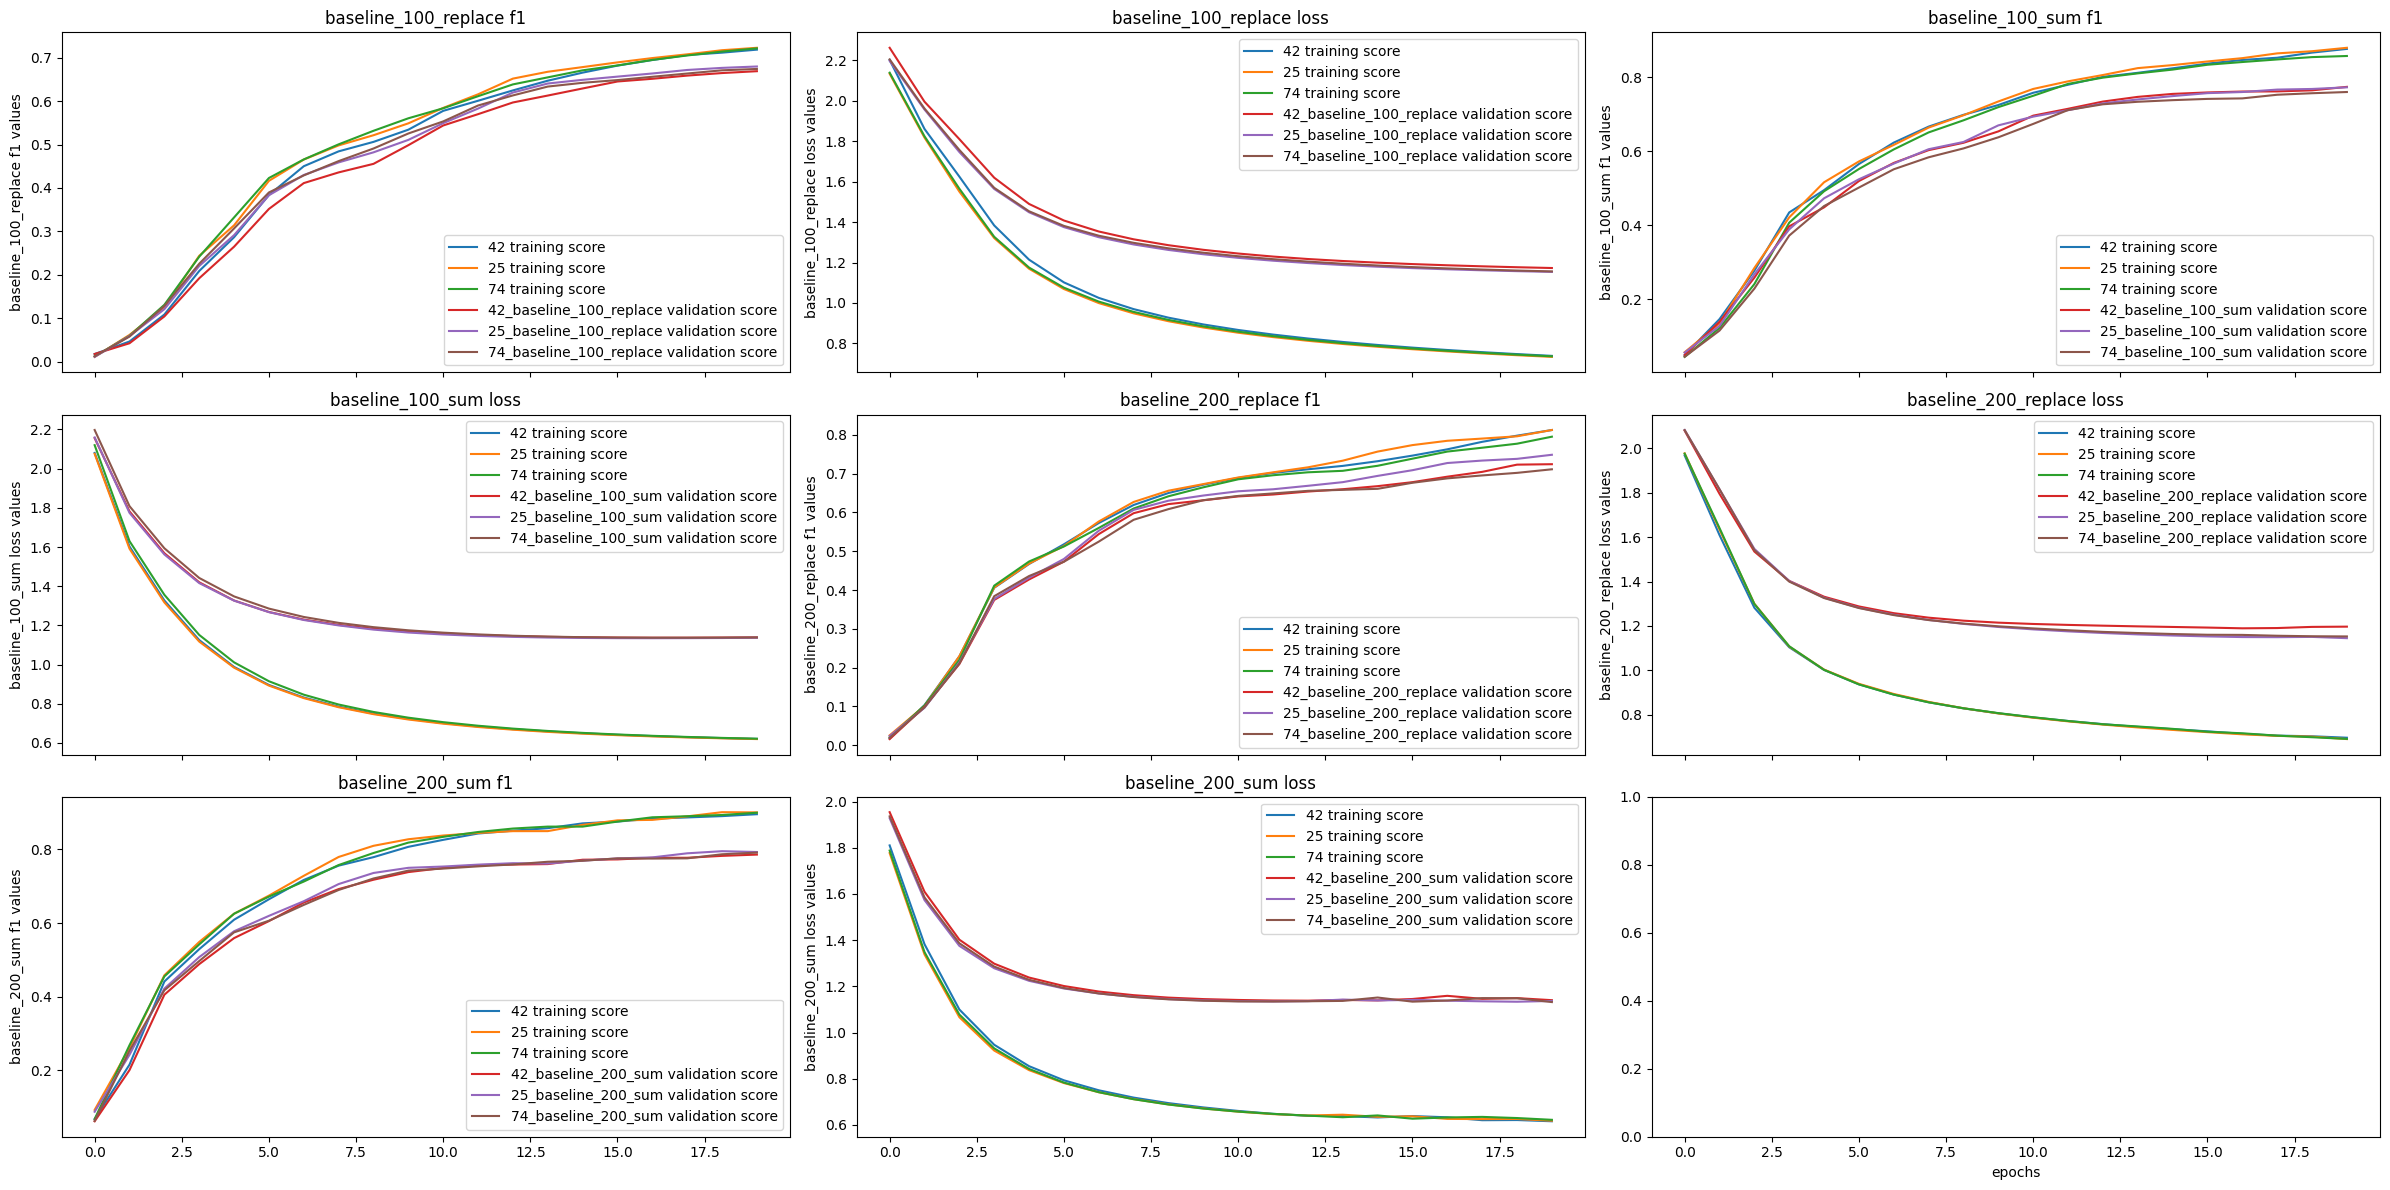

model_name metric  mean_train_difference  max_train_difference  \
0  baseline_100_replace     f1               0.011803              0.045588   
1  baseline_100_replace   loss               0.016414              0.074033   
2      baseline_100_sum     f1               0.011723              0.043510   
3      baseline_100_sum   loss               0.009926              0.044195   
4  baseline_200_replace     f1               0.010188              0.036602   
5  baseline_200_replace   loss               0.003639              0.031667   
6      baseline_200_sum     f1               0.010123              0.052712   
7      baseline_200_sum   loss               0.008809              0.044112   

   min_train_difference  mean_val_difference  max_val_difference  \
0              0.000278             0.014229            0.042093   
1              0.002263             0.019827            0.064599   
2              0.001136             0.012454            0.038787   
3              0.000882             0.008949            0.041498   
4              0.000151             0.013540            0.039574   
5              0.000042             0.016119            0.051893   
6              0.000055             0.008828            0.052372   
7              0.000081             0.008878            0.036047   

   min_val_difference  
0            0.000913  
1            0.002431  
2            0.000419  
3            0.000009  
4            0.000123  
5            0.000292  
6            0.000122  
7            0.000238

In [146]:
model_names = unique(results_baseline, lambda e: e['name'])

plots = {}
difference = []
for name in model_names:
    for plot_name in ['f1', 'loss']:   
        all_models = all(results_baseline, lambda e: e['name'] == name)
        _range = range(len(all_models[0]['train_score'][plot_name]))
        t_diff = [np.abs(m[0]['train_score'][plot_name][i] - m[1]['train_score'][plot_name][i]) for m in combinations(all_models,2) for i in _range]
        v_diff = [np.abs(m[0]['val_score'][plot_name][i] - m[1]['val_score'][plot_name][i]) for m in combinations(all_models,2) for i in _range]
        difference.append({
            'model_name':name,
            'metric':plot_name,
            'mean_train_difference': np.mean(t_diff),
            'max_train_difference': max(t_diff),
            'min_train_difference': min(t_diff),
            'mean_val_difference': np.mean(v_diff),
            'max_val_difference': max(v_diff),
            'min_val_difference': min(v_diff),
        })
        plots[name + ' ' + plot_name] = {f'{model["seed"]} training score': model['train_score'][plot_name] for model in all_models}
        plots[name + ' ' + plot_name].update({f'{model["seed"]}_{name} validation score': model['val_score'][plot_name] for model in all_models})


plot_dictionary_lines(plots, 'epochs',x_multiplier=4, y_multiplier=8)
pd.DataFrame(difference)

### Model 1

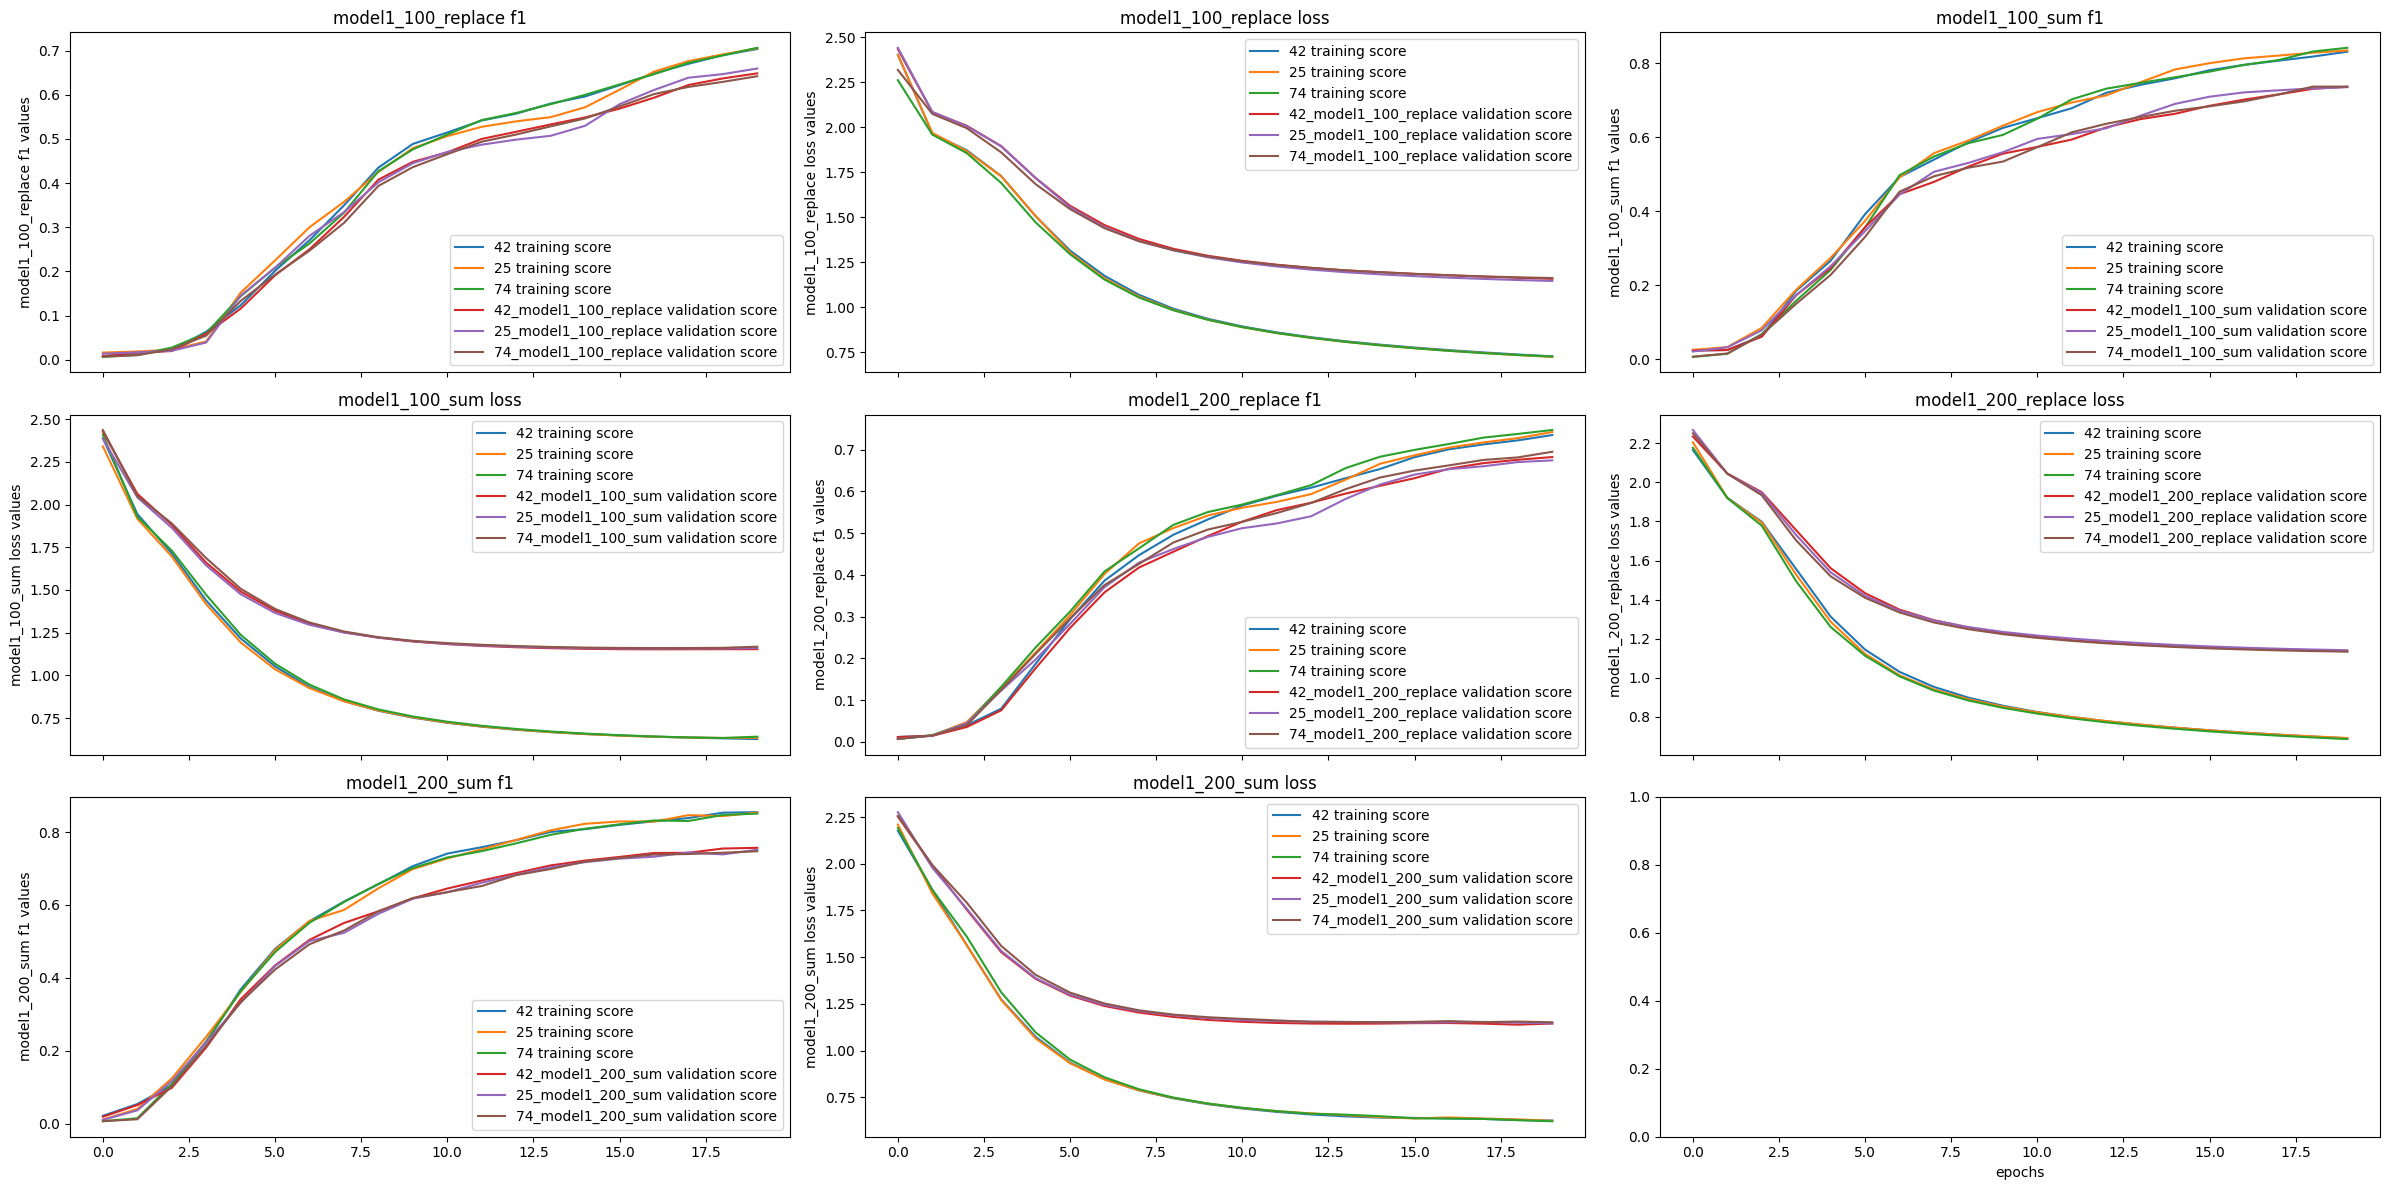

model_name metric  mean_train_difference  max_train_difference  \
0  model1_100_replace     f1               0.010375              0.036874   
1  model1_100_replace   loss               0.011557              0.141163   
2      model1_100_sum     f1               0.012716              0.035773   
3      model1_100_sum   loss               0.011781              0.069964   
4  model1_200_replace     f1               0.013043              0.052297   
5  model1_200_replace   loss               0.011135              0.062132   
6      model1_200_sum     f1               0.008399              0.038945   
7      model1_200_sum   loss               0.008816              0.045675   

   min_train_difference  mean_val_difference  max_val_difference  \
0              0.000320             0.011049            0.033701   
1              0.000011             0.013495            0.123019   
2              0.000004             0.011873            0.027388   
3              0.000147             0.010029            0.050843   
4              0.000385             0.012914            0.049040   
5              0.000069             0.010549            0.052416   
6              0.000542             0.008076            0.039017   
7              0.000120             0.010193            0.037990   

   min_val_difference  
0            0.000588  
1            0.000016  
2            0.000079  
3            0.000456  
4            0.000038  
5            0.000067  
6            0.000180  
7            0.000625

In [147]:
model_names = unique(results_model1, lambda e: e['name'])
plots = {}
difference = []
for name in model_names:
    for plot_name in ['f1', 'loss']:   
        all_models = all(results_model1, lambda e: e['name'] == name)
        _range = range(len(all_models[0]['train_score'][plot_name]))
        t_diff = [np.abs(m[0]['train_score'][plot_name][i] - m[1]['train_score'][plot_name][i]) for m in combinations(all_models,2) for i in _range]
        v_diff = [np.abs(m[0]['val_score'][plot_name][i] - m[1]['val_score'][plot_name][i]) for m in combinations(all_models,2) for i in _range]
        difference.append({
            'model_name':name,
            'metric':plot_name,
            'mean_train_difference': np.mean(t_diff),
            'max_train_difference': max(t_diff),
            'min_train_difference': min(t_diff),
            'mean_val_difference': np.mean(v_diff),
            'max_val_difference': max(v_diff),
            'min_val_difference': min(v_diff),
        })
        plots[name + ' ' + plot_name] = {f'{model["seed"]} training score': model['train_score'][plot_name] for model in all_models}
        plots[name + ' ' + plot_name].update({f'{model["seed"]}_{name} validation score': model['val_score'][plot_name] for model in all_models})


plot_dictionary_lines(plots, 'epochs', x_multiplier=4, y_multiplier=8)
pd.DataFrame(difference)

### Model 2

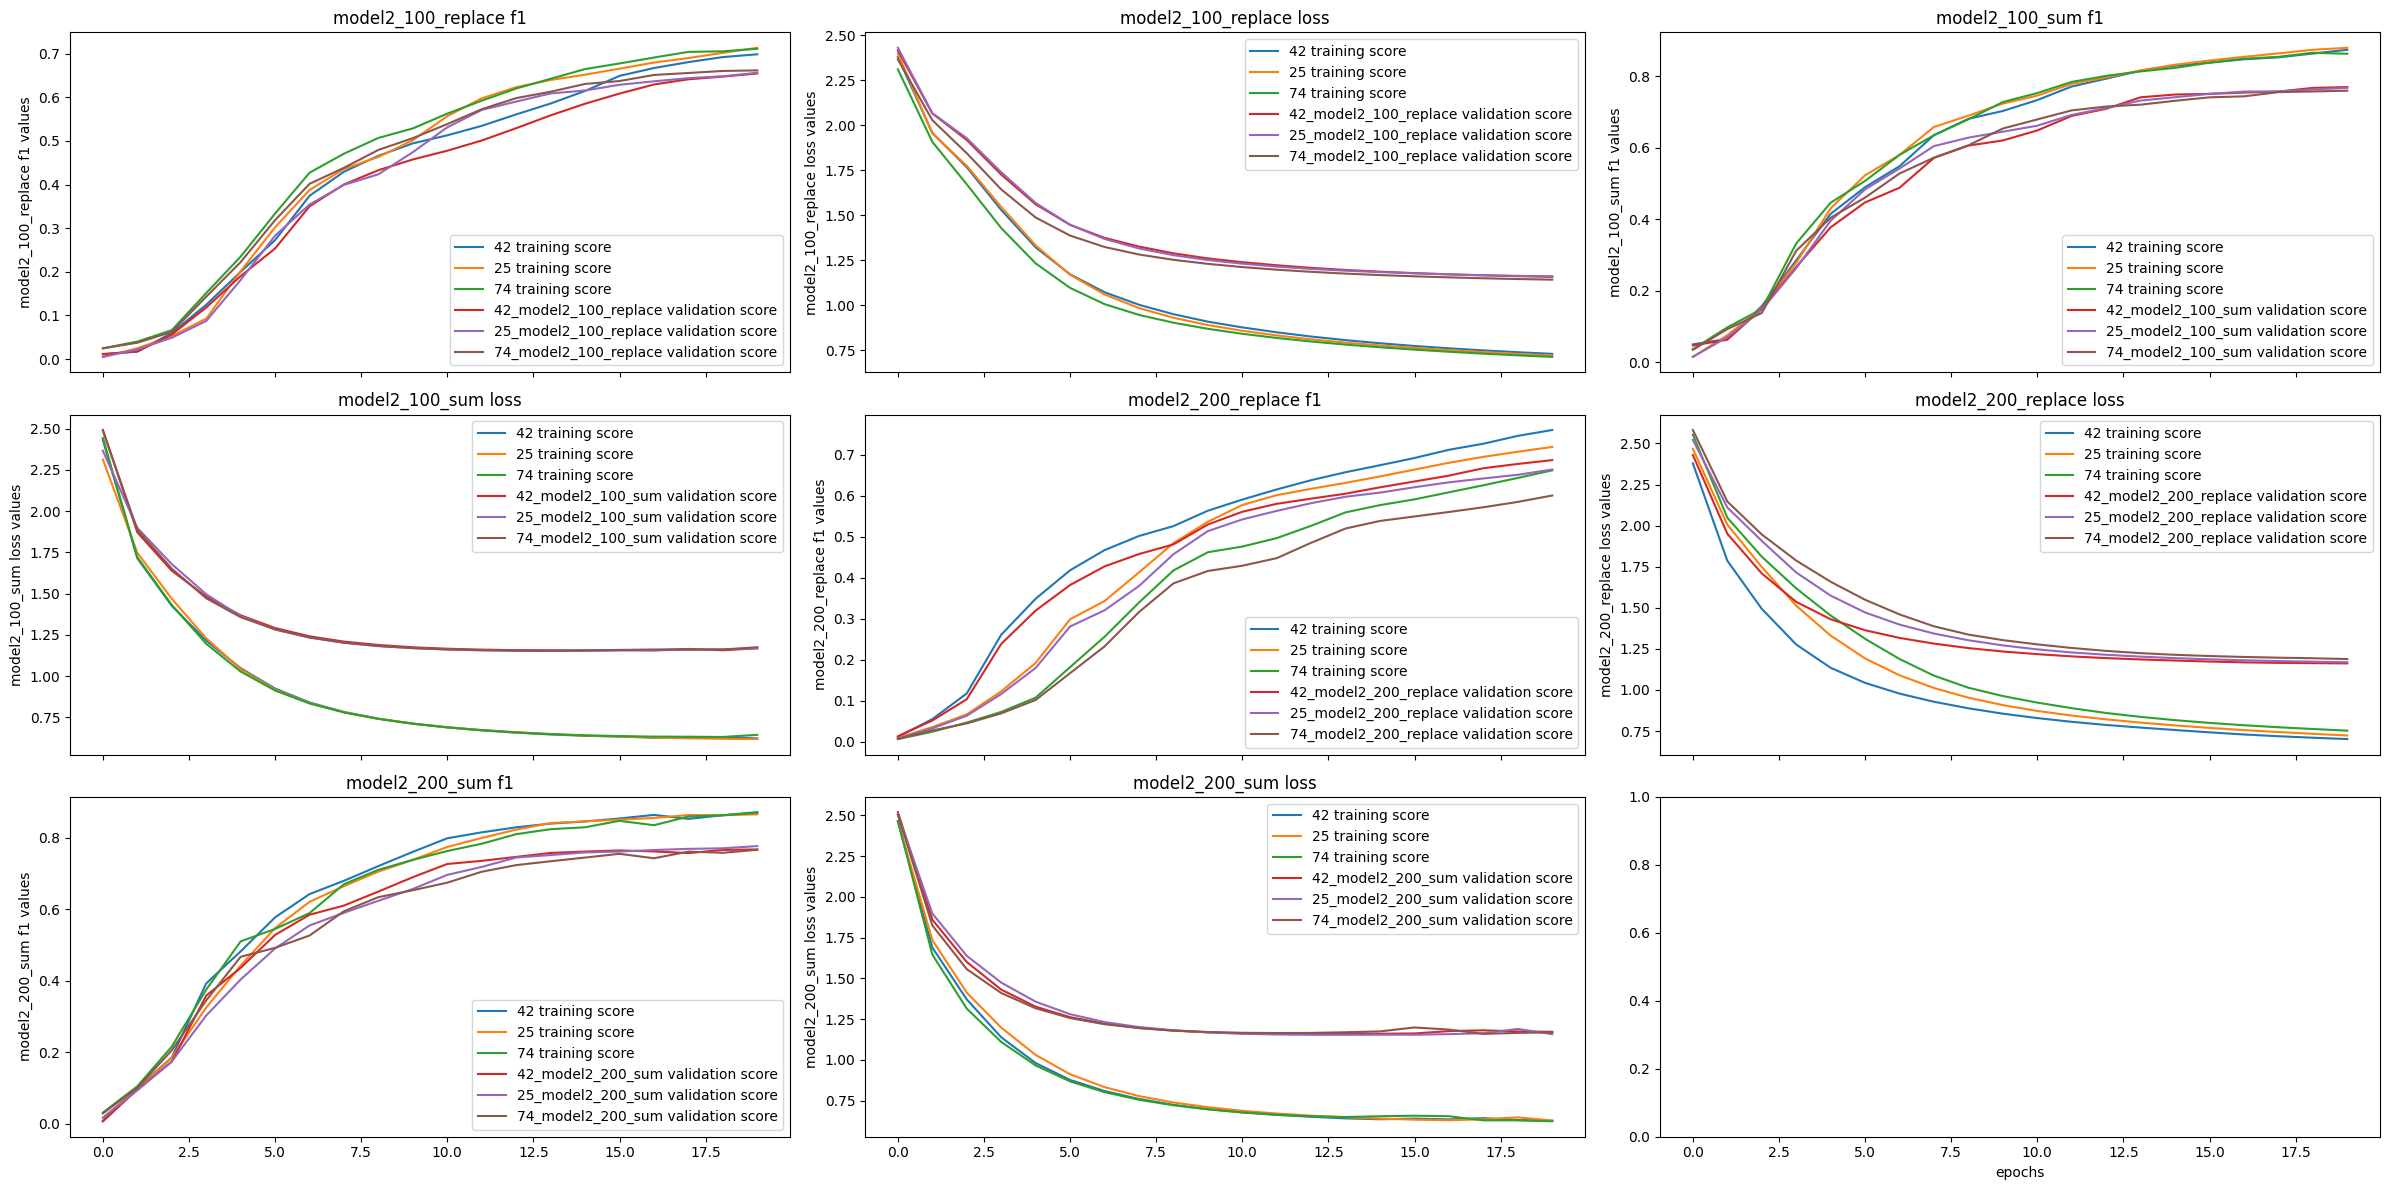

model_name metric  mean_train_difference  max_train_difference  \
0  model2_100_replace     f1               0.025606              0.063093   
1  model2_100_replace   loss               0.032513              0.117381   
2      model2_100_sum     f1               0.012924              0.054216   
3      model2_100_sum   loss               0.011640              0.131322   
4  model2_200_replace     f1               0.080083              0.241251   
5  model2_200_replace   loss               0.097707              0.341499   
6      model2_200_sum     f1               0.016986              0.067915   
7      model2_200_sum   loss               0.020224              0.098020   

   min_train_difference  mean_val_difference  max_val_difference  \
0              0.001512             0.026564            0.071707   
1              0.002204             0.026157            0.095188   
2              0.000074             0.015452            0.053793   
3              0.000123             0.010345            0.126160   
4              0.002295             0.074116            0.218026   
5              0.021943             0.067750            0.251293   
6              0.000084             0.019064            0.063609   
7              0.000224             0.017289            0.081727   

   min_val_difference  
0            0.000745  
1            0.000191  
2            0.000069  
3            0.000104  
4            0.001300  
5            0.006996  
6            0.000781  
7            0.000589

In [148]:
model_names = unique(results_model2, lambda e: e['name'])
plots = {}
difference = []
for name in model_names:
    for plot_name in ['f1', 'loss']:   
        all_models = all(results_model2, lambda e: e['name'] == name)
        _range = range(len(all_models[0]['train_score'][plot_name]))
        t_diff = [np.abs(m[0]['train_score'][plot_name][i] - m[1]['train_score'][plot_name][i]) for m in combinations(all_models,2) for i in _range]
        v_diff = [np.abs(m[0]['val_score'][plot_name][i] - m[1]['val_score'][plot_name][i]) for m in combinations(all_models,2) for i in _range]
        difference.append({
            'model_name':name,
            'metric':plot_name,
            'mean_train_difference': np.mean(t_diff),
            'max_train_difference': max(t_diff),
            'min_train_difference': min(t_diff),
            'mean_val_difference': np.mean(v_diff),
            'max_val_difference': max(v_diff),
            'min_val_difference': min(v_diff),
        })
        plots[name + ' ' + plot_name] = {f'{model["seed"]} training score': model['train_score'][plot_name] for model in all_models}
        plots[name + ' ' + plot_name].update({f'{model["seed"]}_{name} validation score': model['val_score'][plot_name] for model in all_models})
        
plot_dictionary_lines(plots, 'epochs', x_multiplier=4, y_multiplier=8)
pd.DataFrame(difference)

## Fixing the seed 42

In [127]:
SEED = 42

### Baseline performances

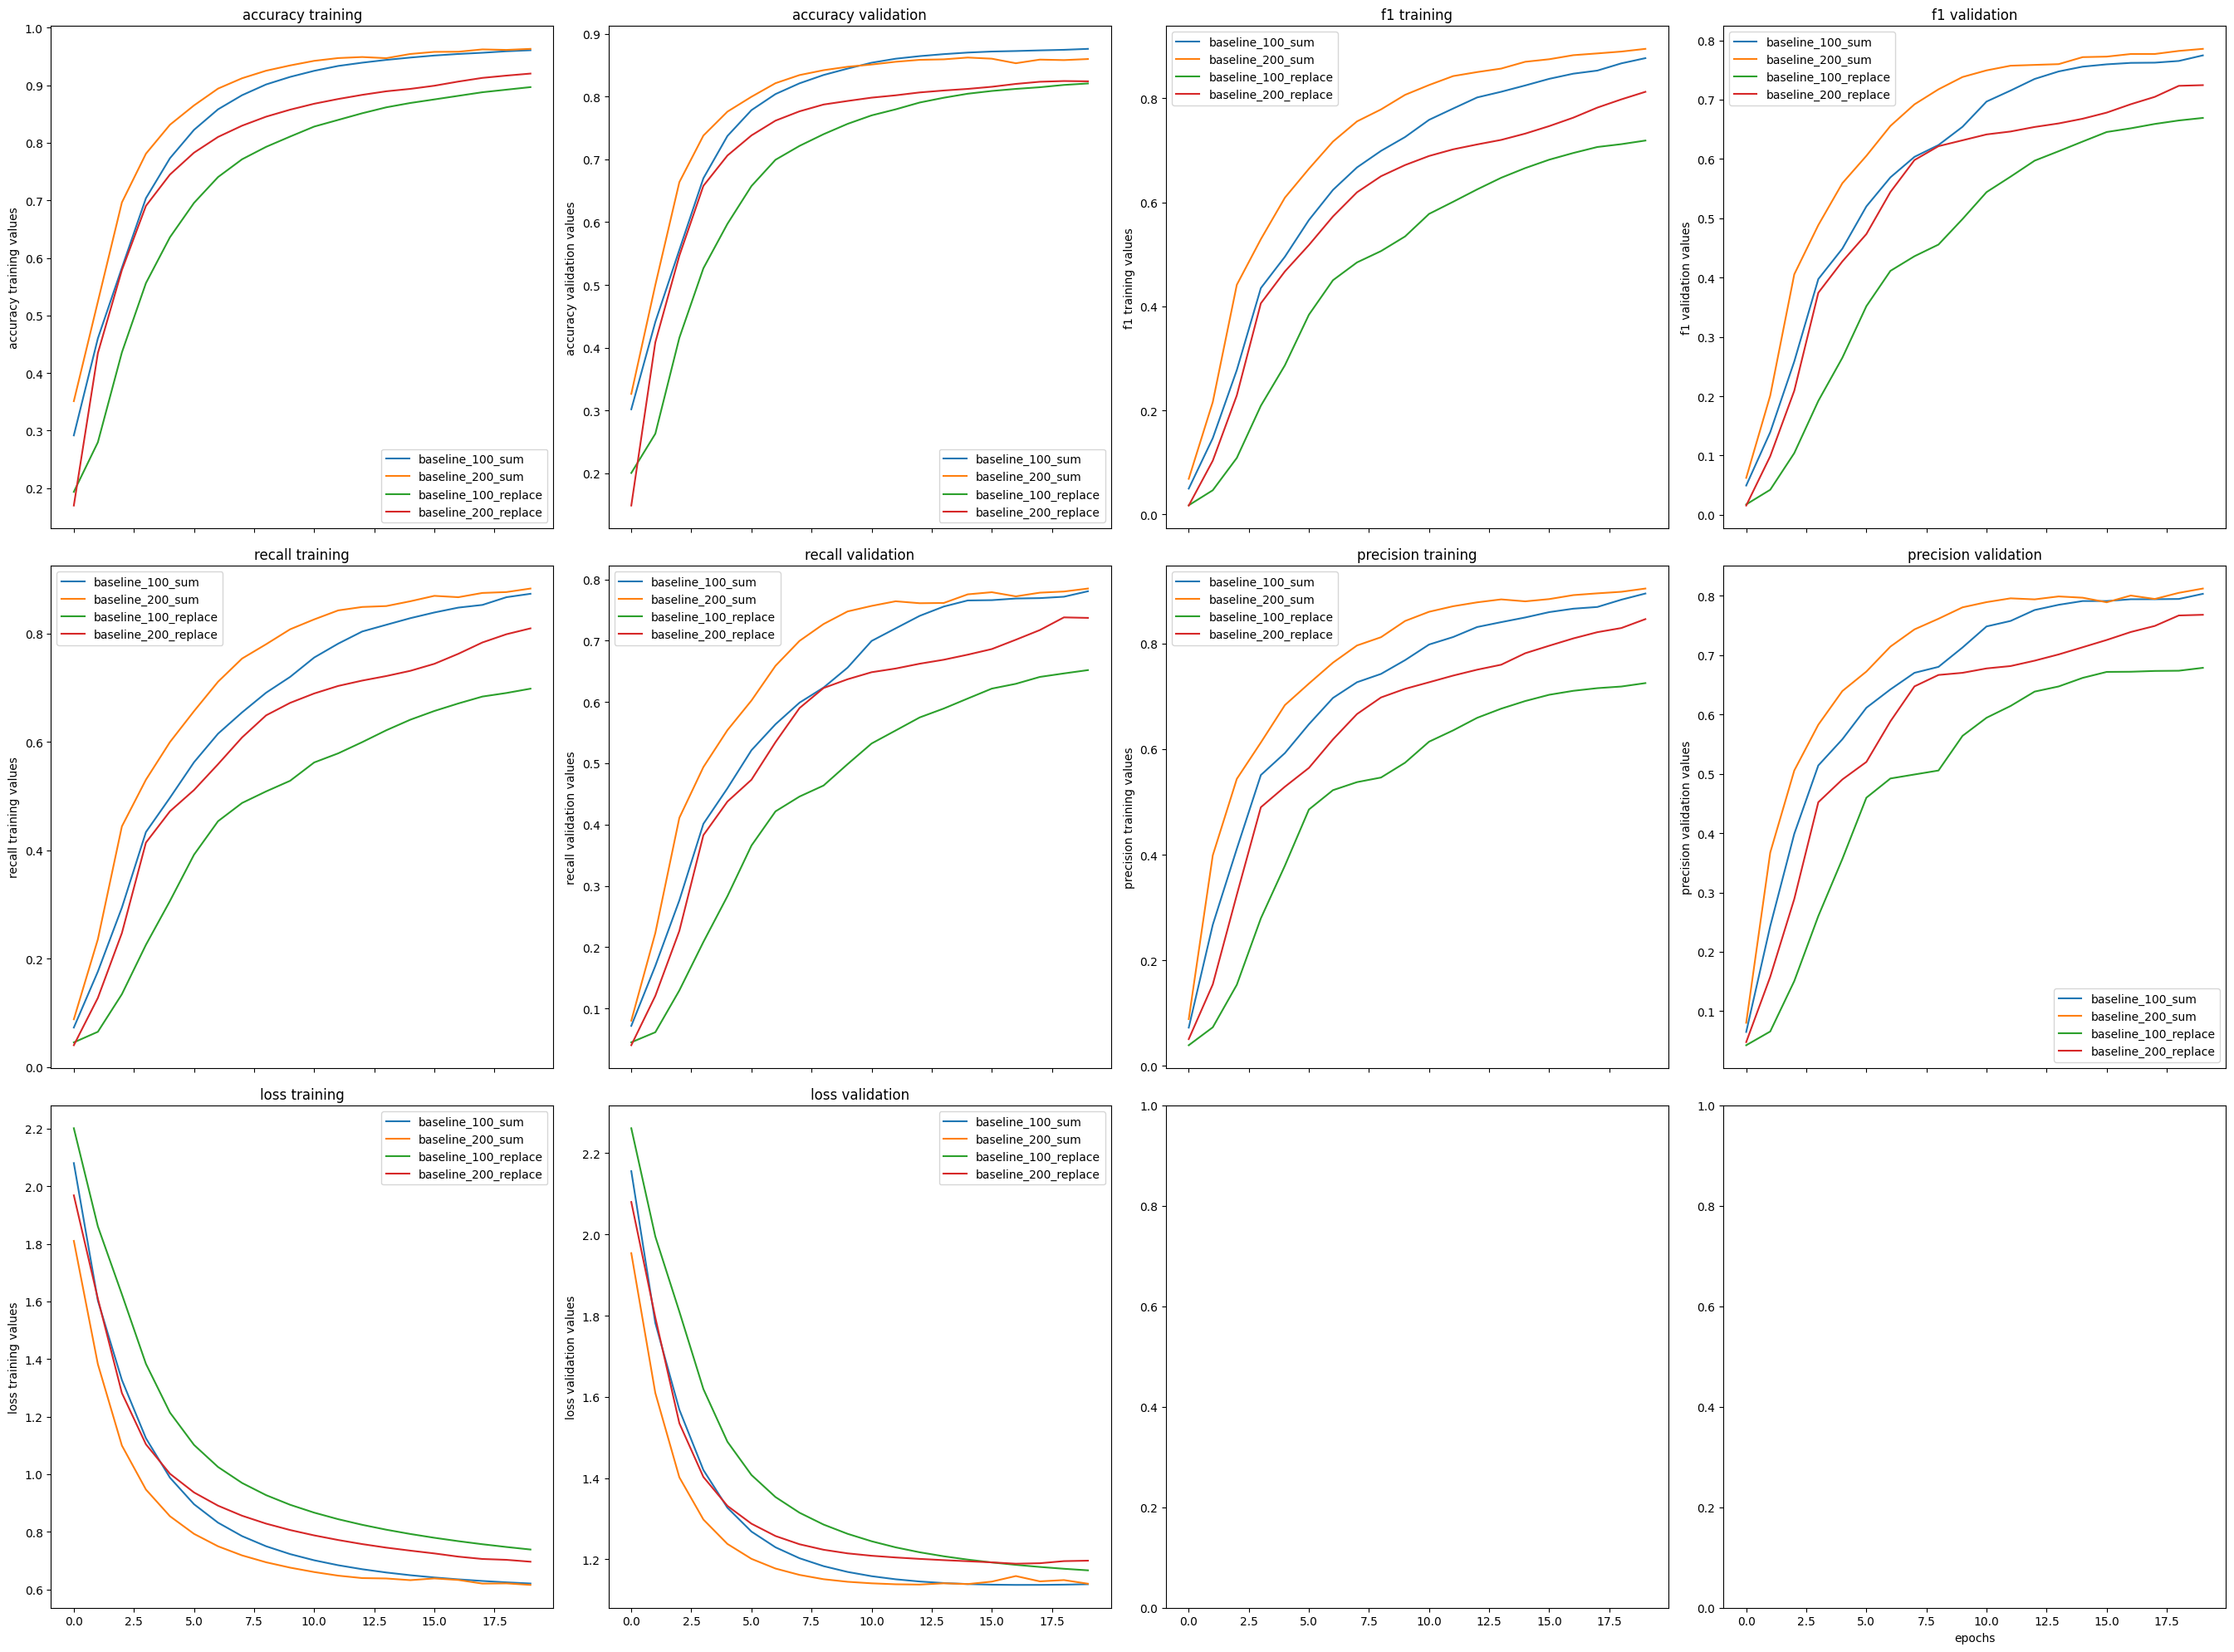

In [149]:
plot_names = list(results_baseline[0]['train_score'].keys())
plots = {}
for plot_name in plot_names:
    all_models = all(results_baseline, lambda e: e['seed'] == SEED)
    for plot_name in plot_names:
        plots[plot_name + ' training'] = {f'{model["name"]}': model['train_score'][plot_name] for model in all_models}
        plots[plot_name + ' validation']= {f'{model["name"]}': model['val_score'][plot_name] for model in all_models}
plot_dictionary_lines(plots, 'epochs',x_multiplier=5, y_multiplier=9)

### Model 1 performances

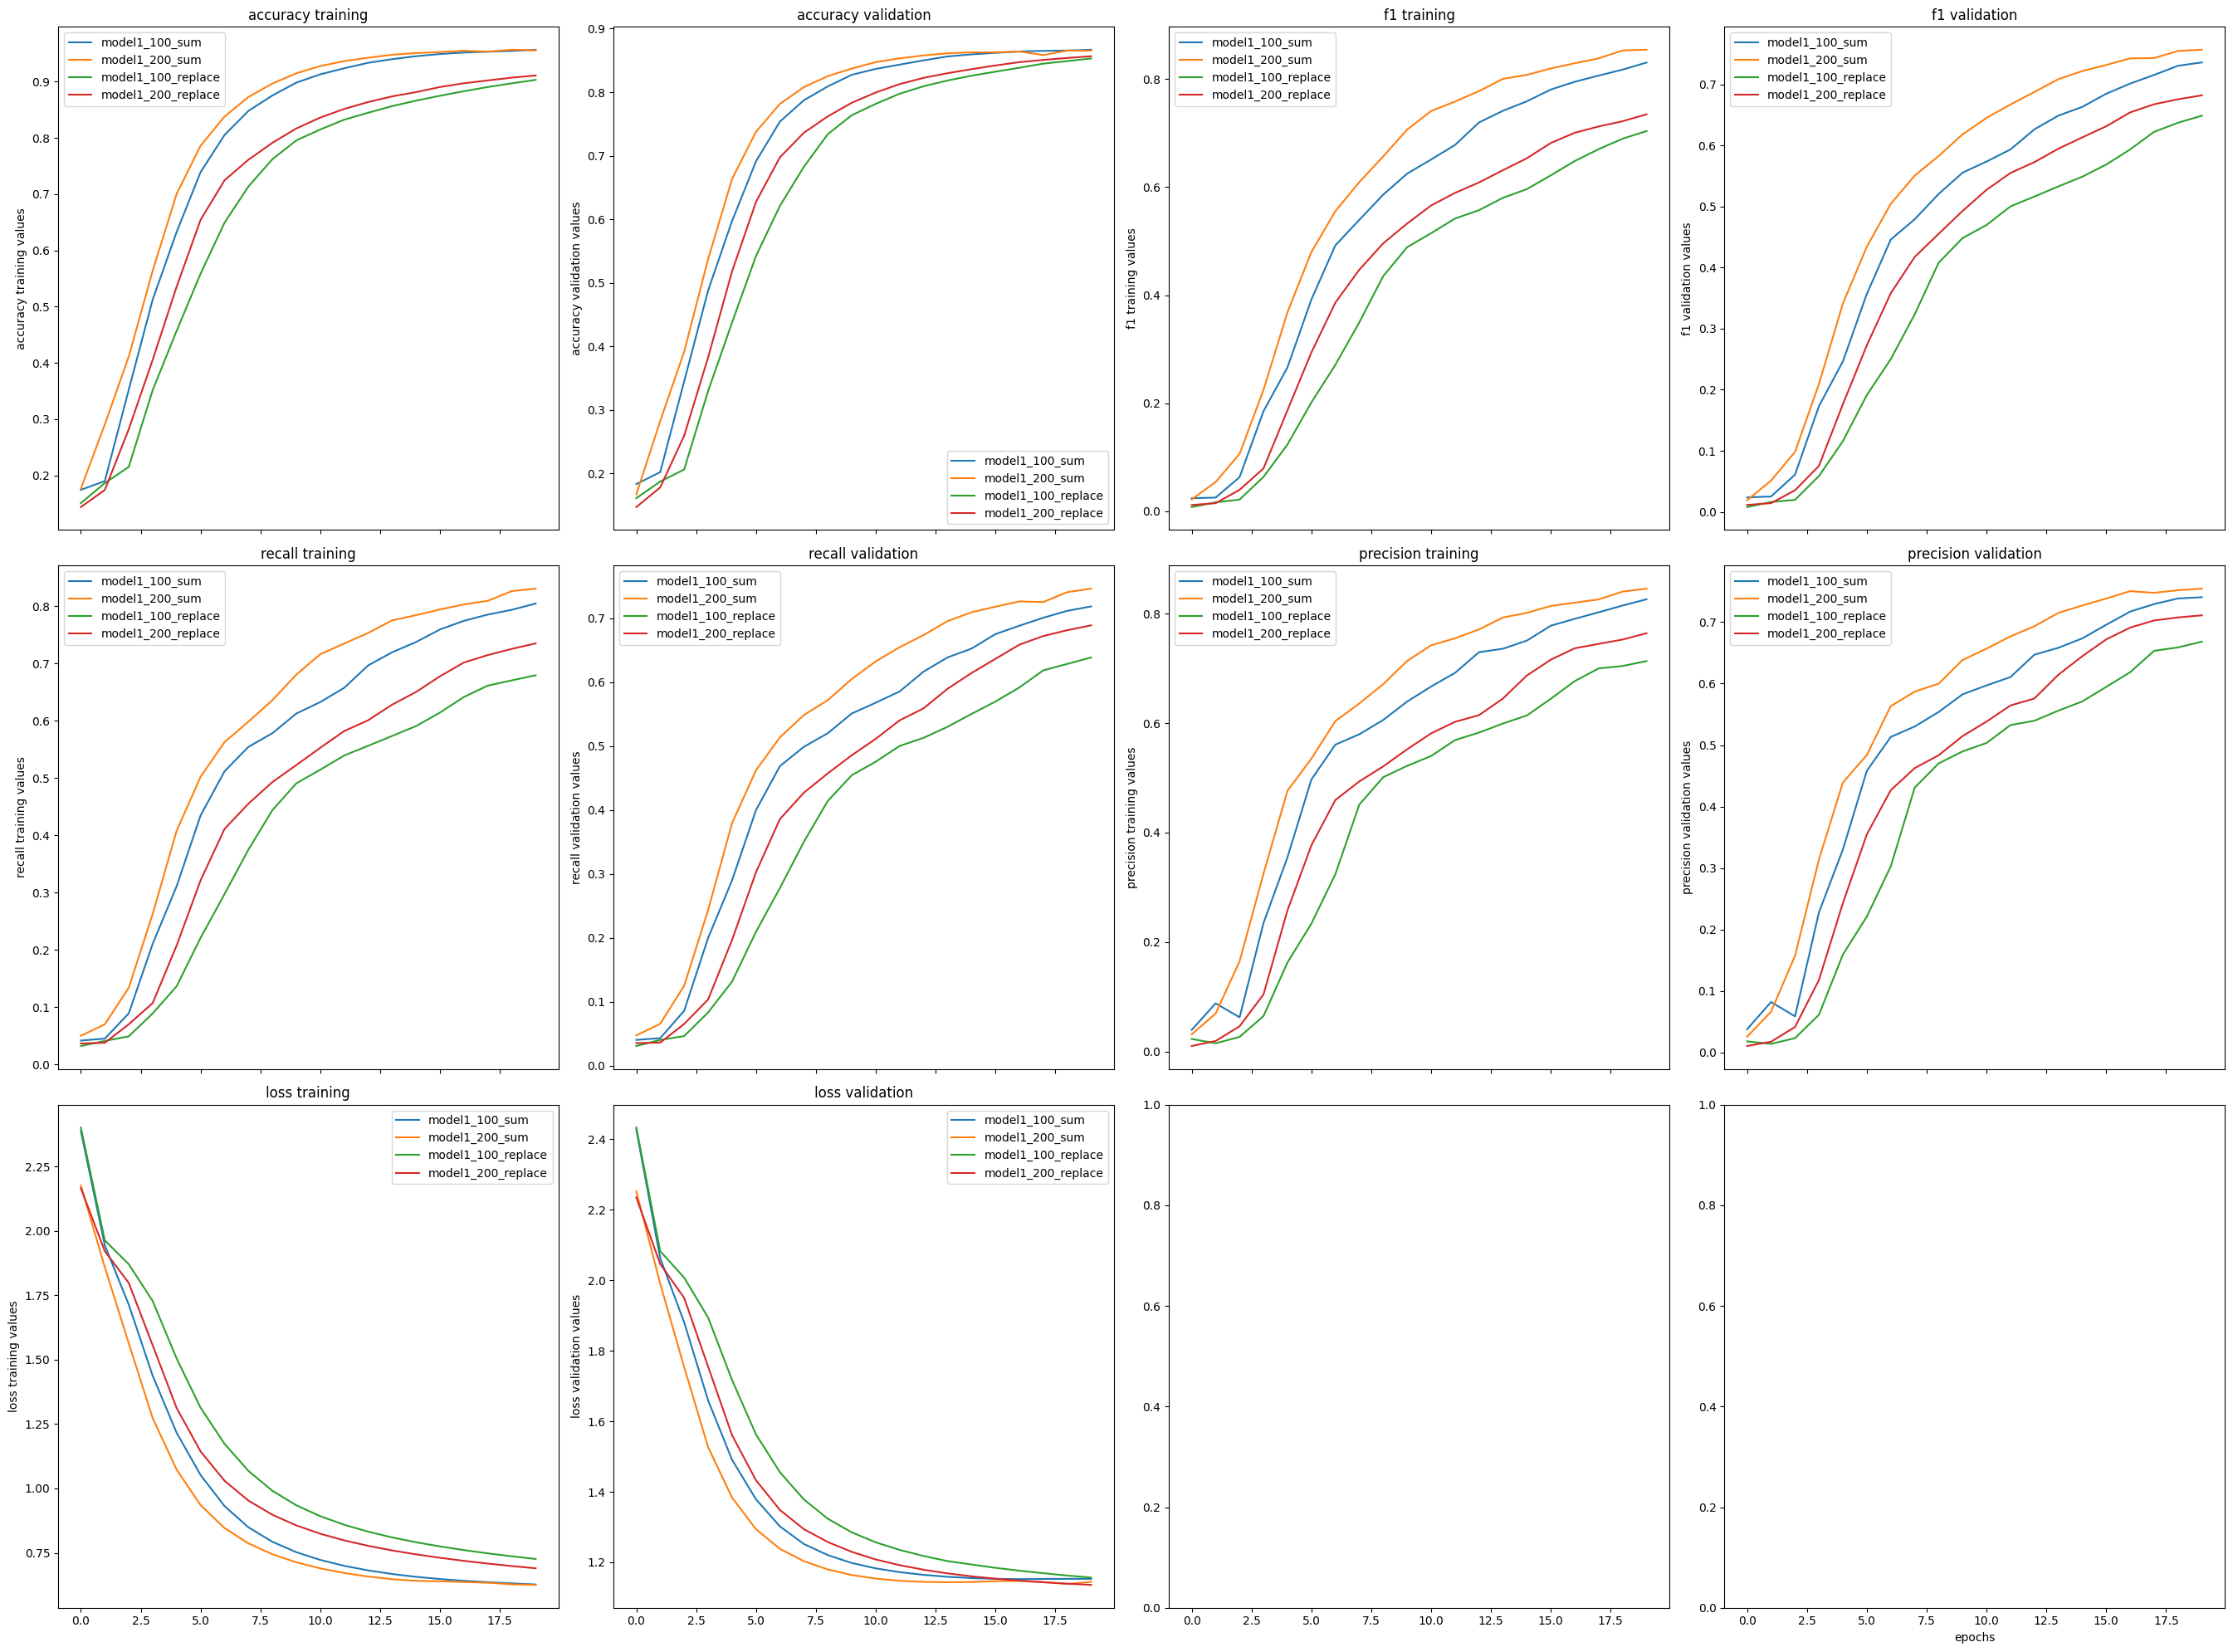

In [150]:
plot_names = list(results_model1[0]['train_score'].keys())
plots = {}
for plot_name in plot_names:
    all_models = all(results_model1, lambda e: e['seed'] == SEED)
    for plot_name in plot_names:
        plots[plot_name + ' training'] = {f'{model["name"]}': model['train_score'][plot_name] for model in all_models}
        plots[plot_name + ' validation']= {f'{model["name"]}': model['val_score'][plot_name] for model in all_models}
plot_dictionary_lines(plots, 'epochs',x_multiplier=5, y_multiplier=9)

### Model 2 performances

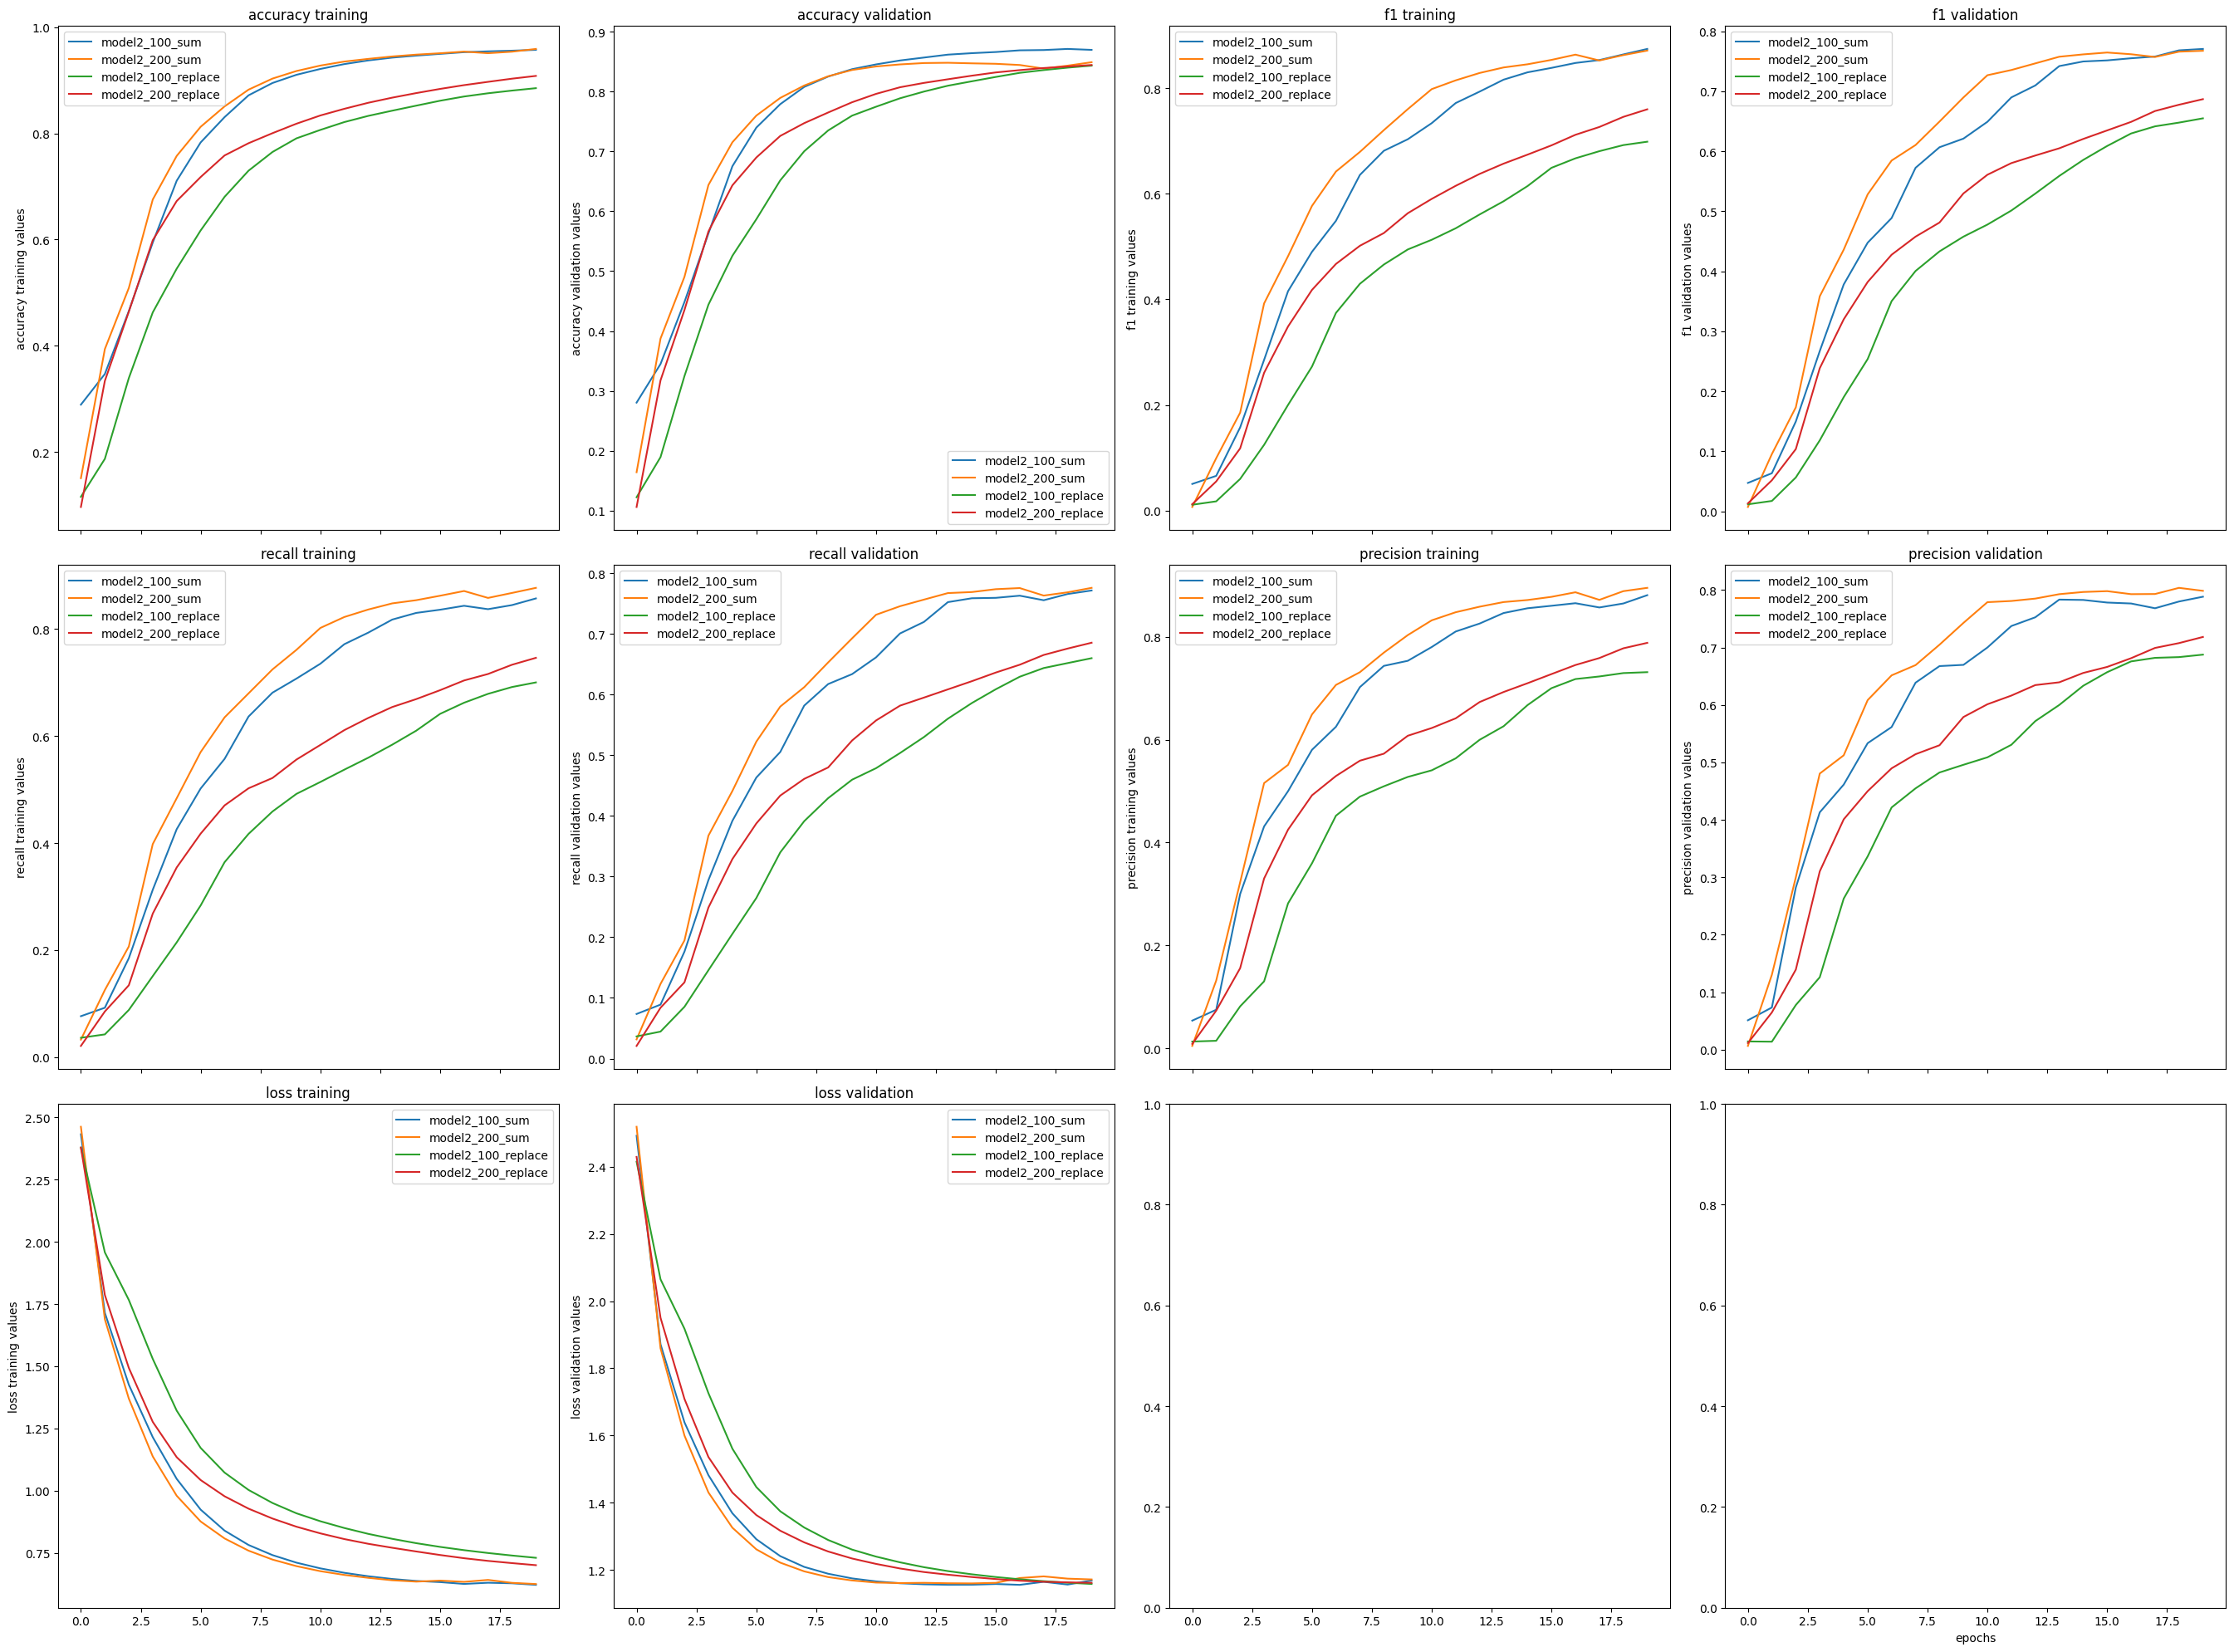

In [151]:
plot_names = list(results_model2[0]['train_score'].keys())
plots = {}
for plot_name in plot_names:
    all_models = all(results_model2, lambda e: e['seed'] == SEED)
    for plot_name in plot_names:
        plots[plot_name + ' training'] = {f'{model["name"]}': model['train_score'][plot_name] for model in all_models}
        plots[plot_name + ' validation']= {f'{model["name"]}': model['val_score'][plot_name] for model in all_models}
plot_dictionary_lines(plots, 'epochs',x_multiplier=5, y_multiplier=9)

## Best models 

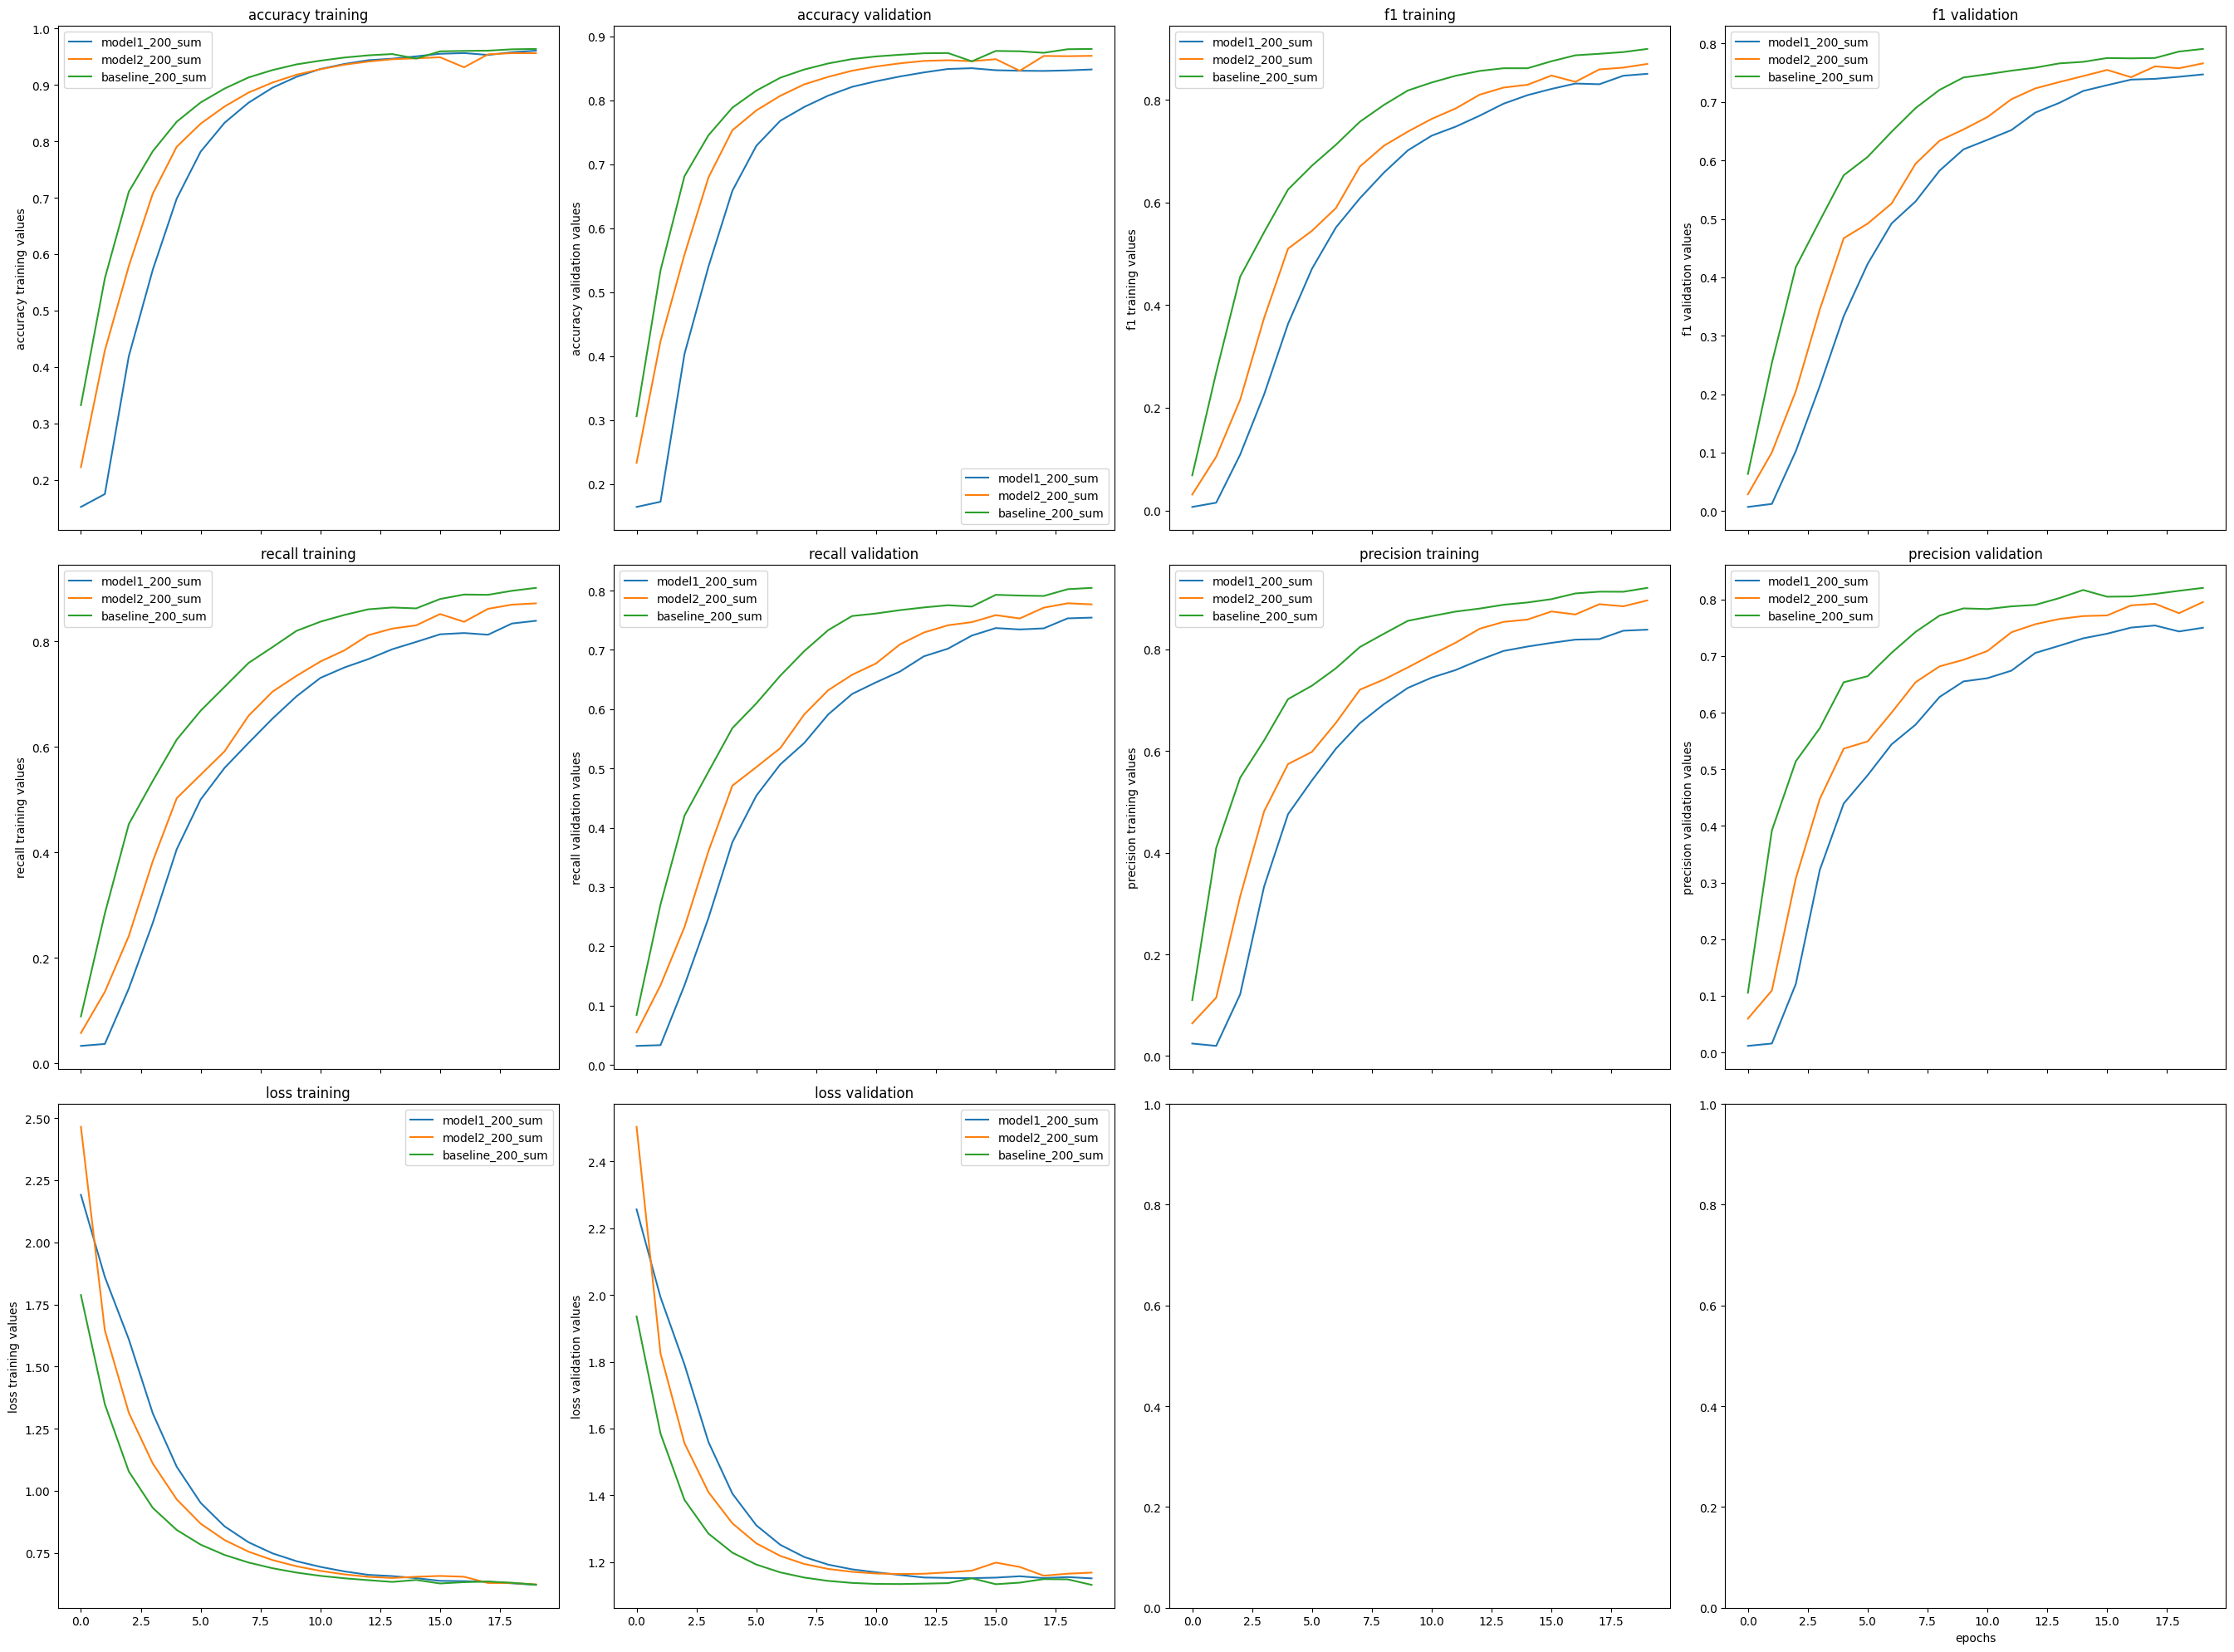

In [253]:
all_models = all(results_model1, lambda e: e['name'] == 'model1_200_sum') +\
    all(results_model2, lambda e: e['name'] == 'model2_200_sum') +\
    all(results_baseline, lambda e: e['name'] == 'baseline_200_sum')

for plot_name in plot_names:
    for plot_name in plot_names:
        plots[plot_name + ' training'] = {f'{model["name"]}': model['train_score'][plot_name] for model in all_models}
        plots[plot_name + ' validation']= {f'{model["name"]}': model['val_score'][plot_name] for model in all_models}
plot_dictionary_lines(plots, 'epochs',x_multiplier=5, y_multiplier=9)

In [155]:
print("The baseline model seems to be the best performing one with a f1 score of:",
    all(results_baseline, lambda e: e['name'] == 'baseline_200_sum')[0]['val_score']['f1'][-1])

The baseline model seems to be the best performing one with a f1 score of: 0.7855496484515602


In [157]:
best_model_parameters = {
        'encoding_dimension': EMBEDDING_DIM,
        'lstm_hidden_size':200,
        'out_shape':OUTPUT_SIZE,
        'embedding_type':'Sum'
}
best_model = Baseline(**best_model_parameters)
random.seed(SEED)
best_model.train_network(train_loader,validation_loader,
    device=device, 
    loss_function=nn.CrossEntropyLoss(weights), 
    metrics={'accuracy':masked_accuracy, 'f1':masked_f1_score, 'recall': masked_recall, 'precision': masked_precision},
    learning_rate=.001,
    output_extraction_function=lambda x: torch.max(x, -1)[1].view(-1).cpu(),
    epochs=20,
    verbose=True
);

EPOCH 1 training loss: 1.8027374744415283 - validation loss: 1.9479774236679077                                                                                                                                                                                                                                                                                                                                                                                                                                                              
EPOCH 1 training accuracy: 0.3542841853494219 - validation accuracy: 0.3200294889848828
EPOCH 1 training f1: 0.07650242781586142 - validation f1: 0.06930614421133027
EPOCH 1 training recall: 0.09442364725826398 - validation recall: 0.08547685009160999
EPOCH 1 training precision: 0.10784511428396683 - validation precision: 0.10349381672716476
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss: 1.369

# [Task 6 - 1.0 points] Error Analysis

You are tasked to evaluate your best performing model.

In [198]:
x_test, y_test = transform_data(test_data, vocabulary, pos_encoding)

In [199]:
x_test = x_test.to(device)
x_validation = x_validation.to(device)

In [205]:
validation_prediction = best_model(x_validation)
test_prediction = best_model(x_test)

In [206]:
extraction_function = lambda x: torch.max(x, -1)[1].view(-1).cpu()
cat_validation_prediction = extraction_function(validation_prediction)
y_validation_true = extraction_function(y_validation)
cat_test_prediction = extraction_function(test_prediction)
y_test_true = extraction_function(y_test)

In [207]:
print(f'accuracy on test set: {masked_accuracy(cat_test_prediction, y_test_true)}')
print(f'f1 on test set: {masked_f1_score(cat_test_prediction, y_test_true)}')
print(f'recall on test set: {masked_recall(cat_test_prediction, y_test_true)}')
print(f'precision on test set: {masked_precision(cat_test_prediction, y_test_true)}')

accuracy on test set: 0.8806884480746792
f1 on test set: 0.7648787293164596
recall on test set: 0.8132587292705675
precision on test set: 0.8445589788984791


In [215]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues, fig_size =(8, 6)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized Confusion Matrix'
        else:
            title = 'Confusion Matrix, without Normalization'

    # Convert PyTorch tensors to NumPy arrays
    y_true_np = y_true.cpu().numpy() if torch.is_tensor(y_true) else np.array(y_true)
    y_pred_np = y_pred.cpu().numpy() if torch.is_tensor(y_pred) else np.array(y_pred)

    # Compute confusion matrix
    cm = confusion_matrix(y_true_np, y_pred_np)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix:")
    else:
        print('Confusion Matrix, without Normalization:')


    # Plot the confusion matrix
    plt.figure(figsize=fig_size)
    sns.heatmap(cm, annot=True, fmt=".2f", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Normalized Confusion Matrix:


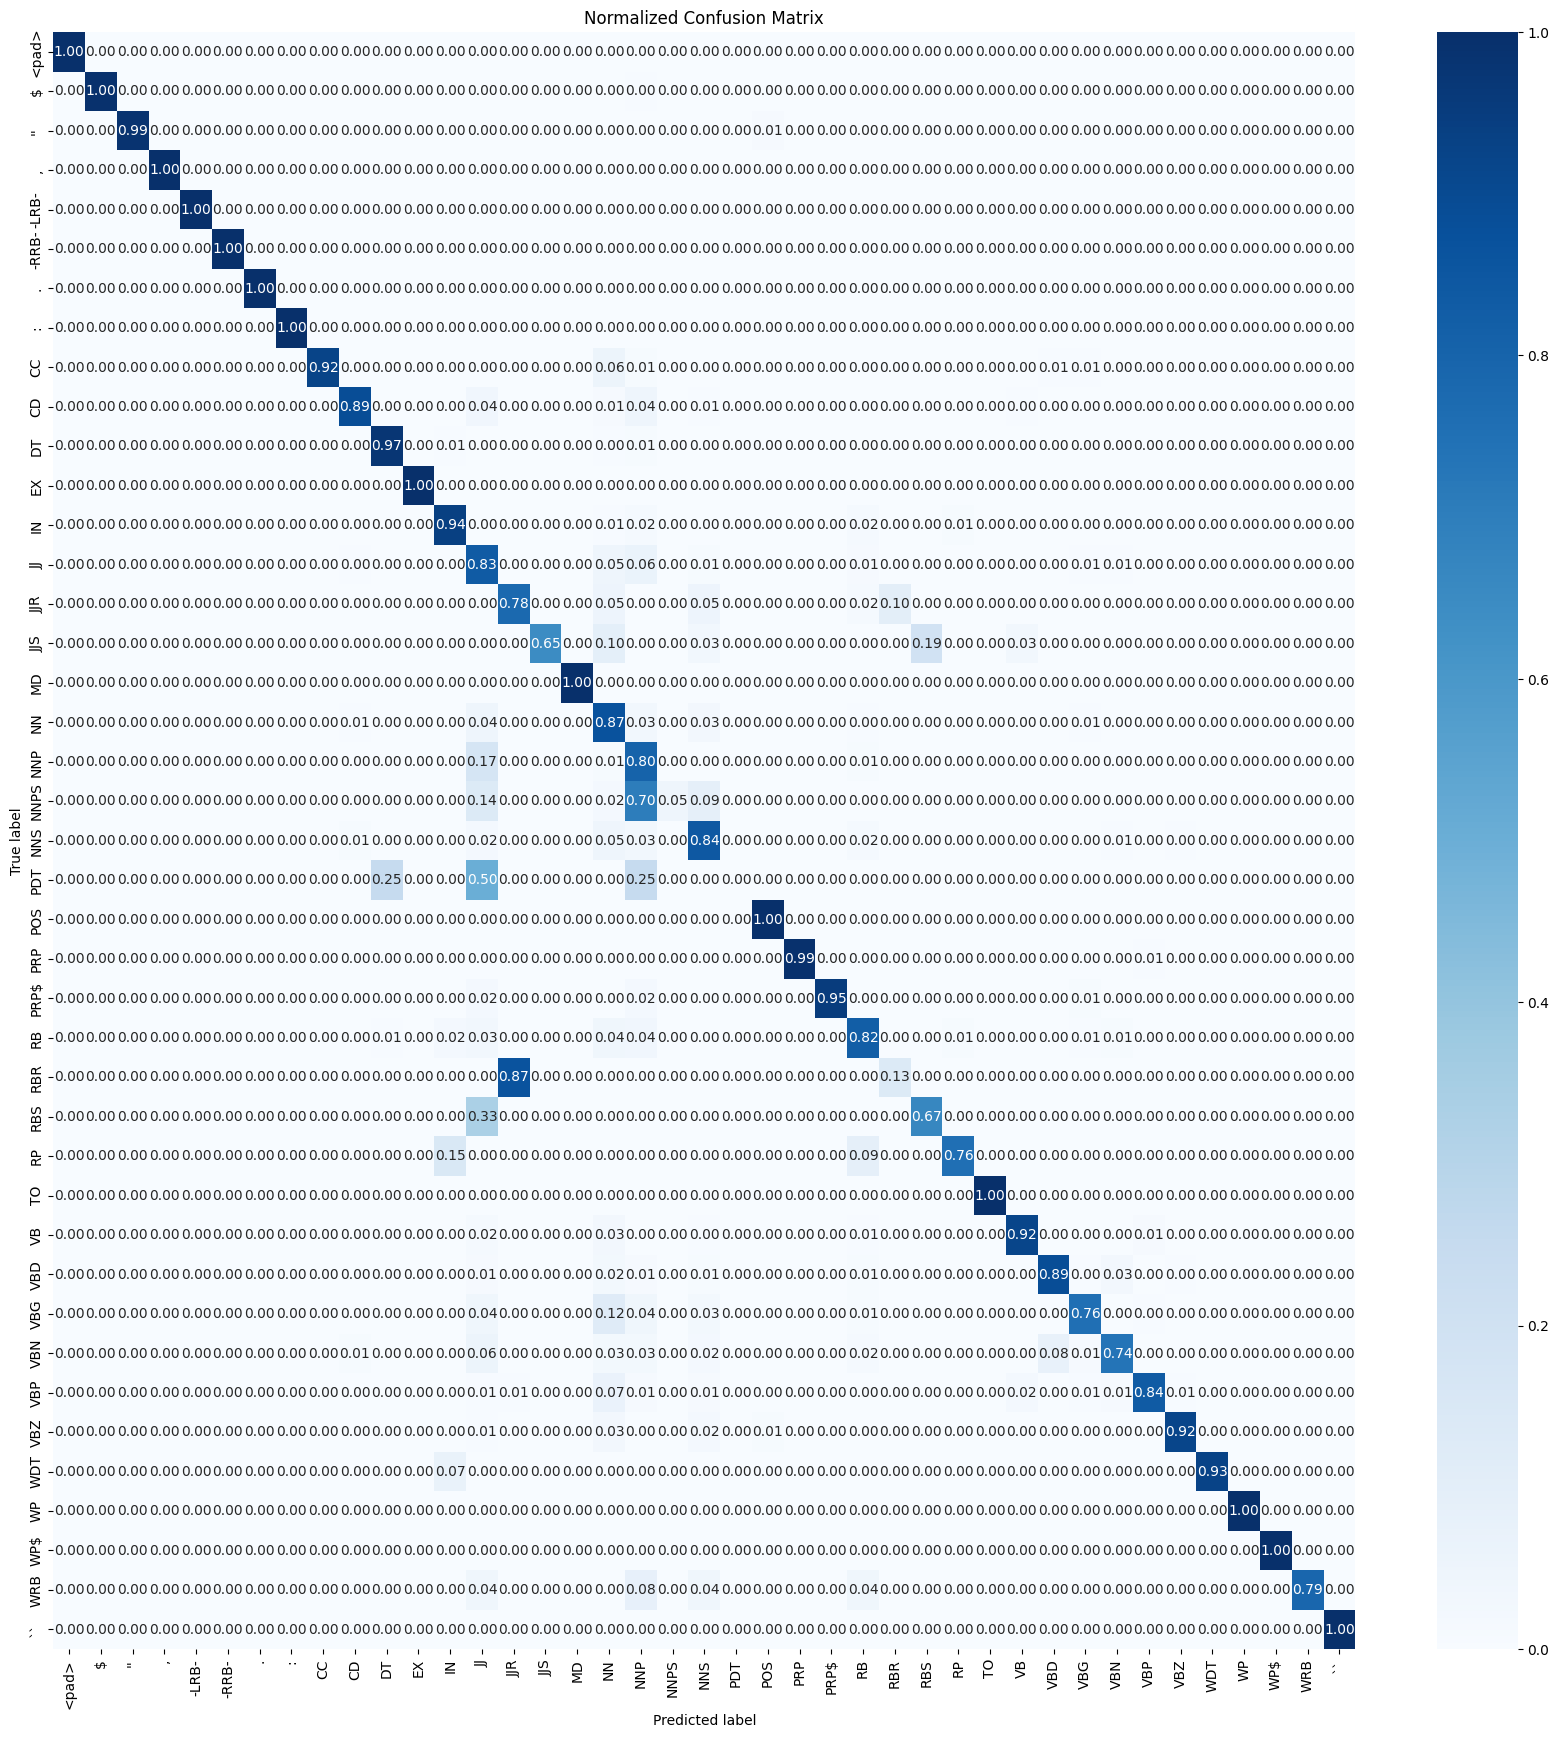

In [234]:
test_classes = list(np.unique(test_data['pos label'])) + ['<pad>']
ordered_test_classes = []

for c in pos_encoding.pos2idx.keys():
    if c in test_classes:
        ordered_test_classes.append(c)

plot_confusion_matrix(y_test_true, cat_test_prediction, ordered_test_classes, normalize=True, fig_size=(21,21))

Normalized Confusion Matrix:


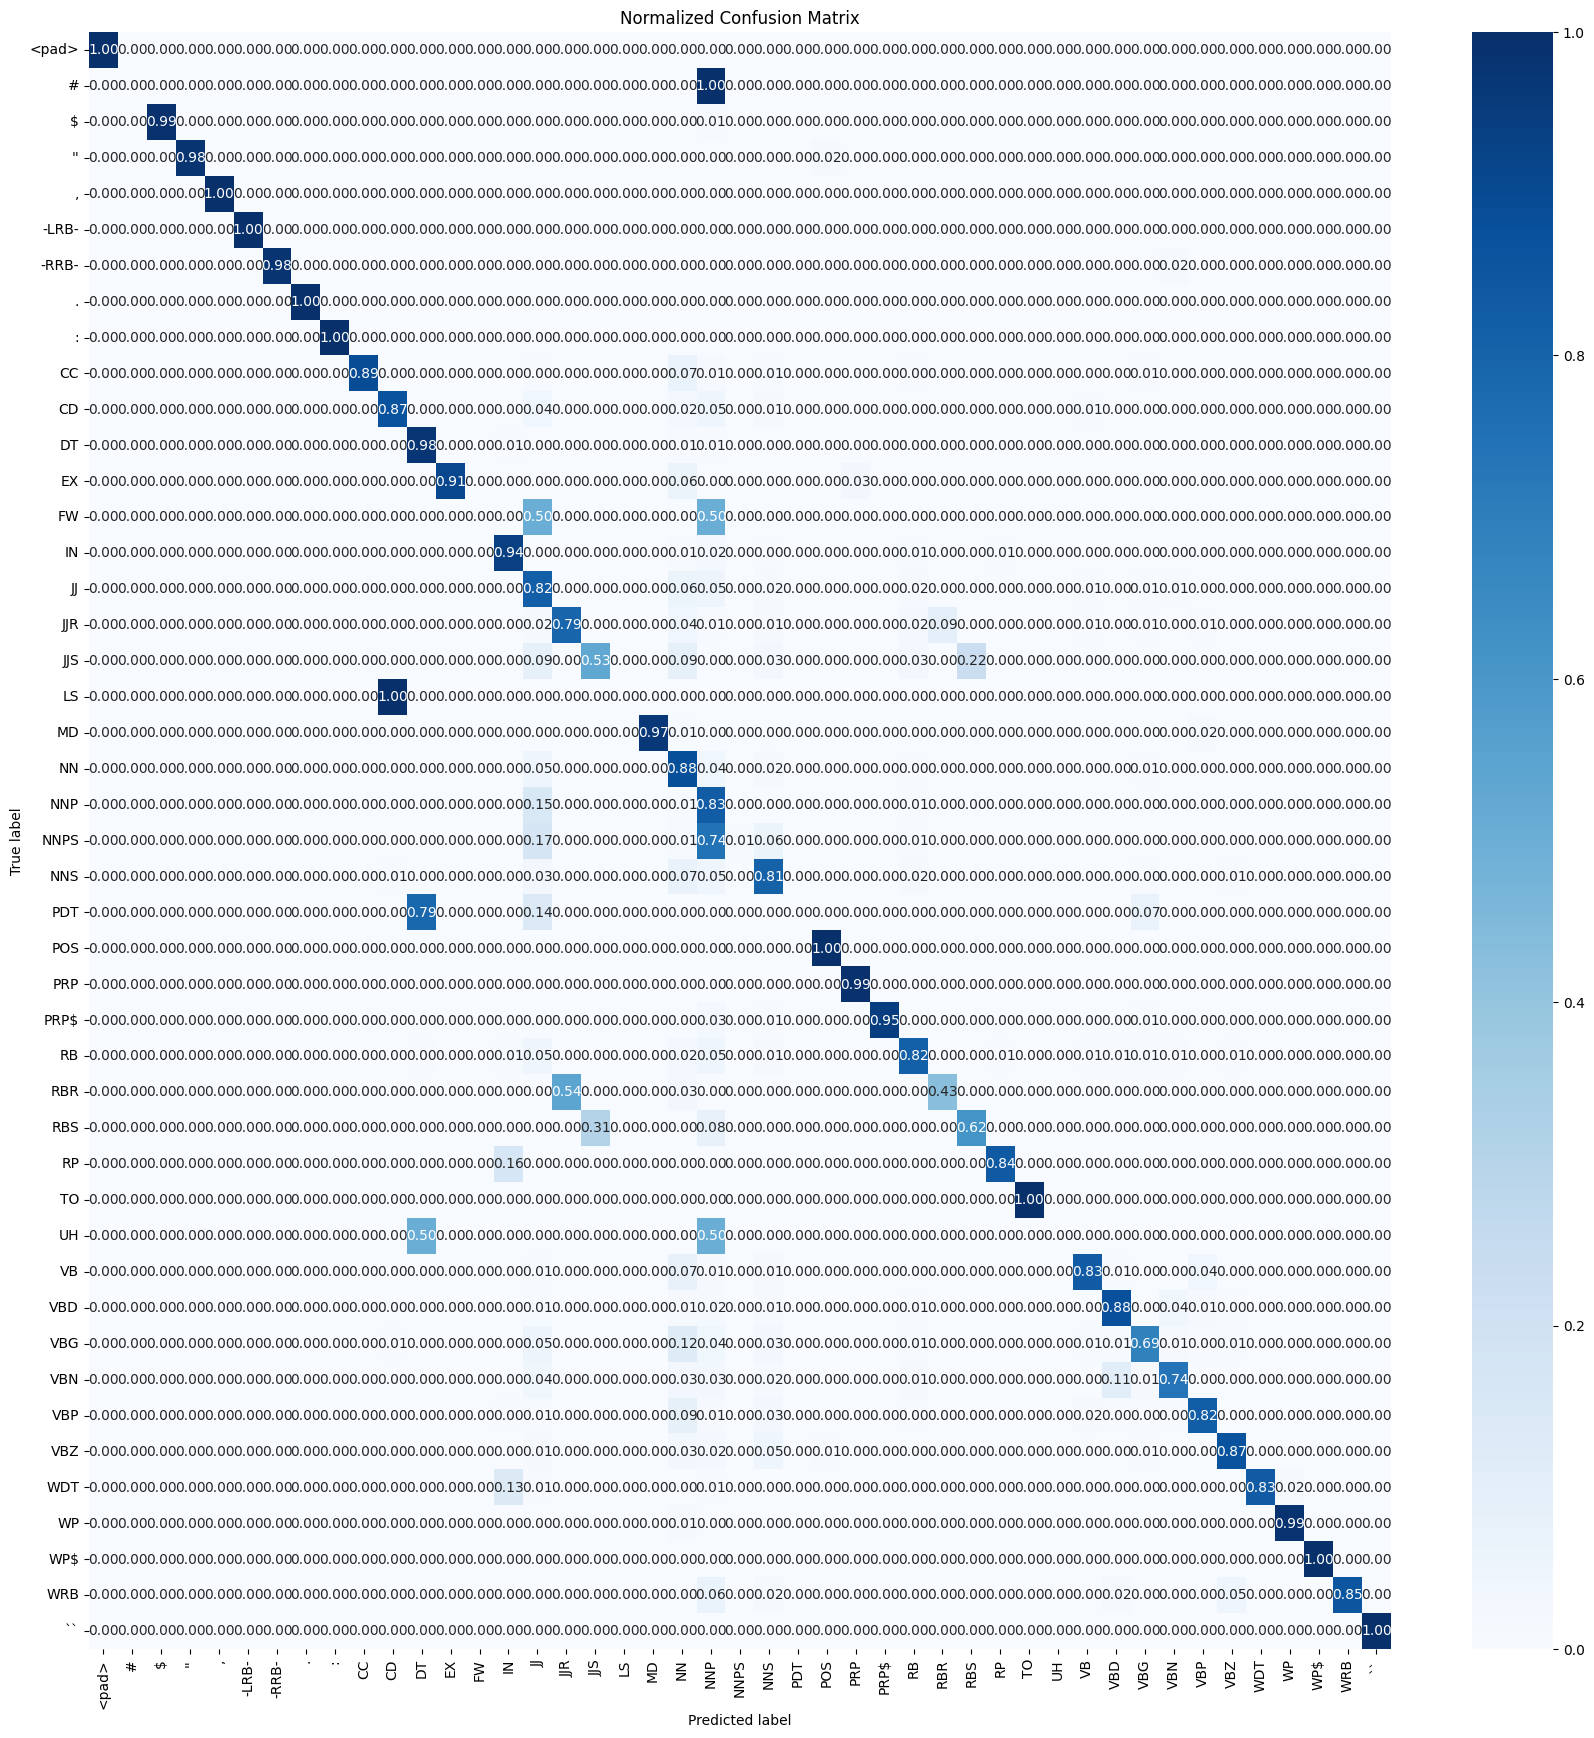

In [232]:
validation_classes = list(np.unique(validation_data['pos label'])) + ['<pad>']
oredered_validation_classes = []

for c in pos_encoding.pos2idx.keys():
    if c in validation_classes:
        oredered_validation_classes.append(c)
plot_confusion_matrix(y_validation_true, cat_validation_prediction, oredered_validation_classes, normalize=True, fig_size=(21,21))

In [245]:
test_matrix = confusion_matrix(y_test_true, cat_test_prediction, normalize='true')
validation_matrix = confusion_matrix(y_validation_true, cat_validation_prediction, normalize='true')

test_correct = [(test_matrix[i,i], ordered_test_classes[i]) for i in range(test_matrix.shape[0])]
test_correct.sort(reverse=True, key= lambda x: x[0])
validation_correct = [(validation_matrix[i,i], oredered_validation_classes[i]) for i in range(validation_matrix.shape[0])]
validation_correct.sort(reverse=True, key= lambda x: x[0])

In [249]:
print("The most errors on the test set have been done on the classes:")
for i in range(1, 11):
    print(f"{i}) {test_correct[-i][1]} with {'{:1.2f}'.format((1 - test_correct[-i][0]) * 100)} of wrong values")

The most errors on the test set have been done on the classes:
1) PDT with 100.00 of wrong values
2) NNPS with 95.45 of wrong values
3) RBR with 86.67 of wrong values
4) JJS with 35.48 of wrong values
5) RBS with 33.33 of wrong values
6) VBN with 26.23 of wrong values
7) VBG with 24.43 of wrong values
8) RP with 24.24 of wrong values
9) JJR with 22.03 of wrong values
10) WRB with 20.83 of wrong values


In [250]:
print("The most errors on the validation set have been done on the classes:")
for i in range(1, 11):
    print(f"{i}) {validation_correct[-i][1]} with {'{:1.2f}'.format((1 - test_correct[-i][0]) * 100)} of wrong values")

The most errors on the validation set have been done on the classes:
1) UH with 100.00 of wrong values
2) PDT with 95.45 of wrong values
3) LS with 86.67 of wrong values
4) FW with 35.48 of wrong values
5) # with 33.33 of wrong values
6) NNPS with 26.23 of wrong values
7) RBR with 24.43 of wrong values
8) JJS with 24.24 of wrong values
9) RBS with 22.03 of wrong values
10) VBG with 20.83 of wrong values


In [251]:
print("The classes:")
for label in validation_classes:
    if not label in test_classes:
        print(f'- {label}')
print("Are not present in the test set")

The classes:
- #
- FW
- LS
- UH
Are not present in the test set


# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Punctuation

**Do not** remove punctuation from documents since it may be helpful to the model.

You should **ignore** it during metrics computation.

If you are curious, you can run additional experiments to verify the impact of removing punctuation.

# The End